# SetUp

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
import os
from scipy import stats
from collections import Counter
from datetime import datetime
import itertools
import random

# Practical 1:

## Download Dataset

In [2]:
# URL of the dataset
url = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"
zip_file = "ml-32m.zip"
extract_folder = "ml-32m"

print(f"Starting download of {url}...")

# Use !wget to download the file in Colab
# -q makes it quiet (less output)
!wget -q $url

print("Download complete.")

# Check if the file was downloaded successfully
if os.path.exists(zip_file):
    print(f"Successfully downloaded {zip_file}.")

    # Unzip the file
    print(f"Unzipping {zip_file}...")
    # -o overwrites existing files without asking
    # -d specifies the directory to extract to
    !unzip -o $zip_file -d $extract_folder

    print(f"Successfully unzipped to '{extract_folder}' folder.")

    # List the contents of the extracted folder
    print(f"\nContents of {extract_folder}:")
    !ls -l $extract_folder
else:
    print(f"Error: {zip_file} was not downloaded.")

Starting download of https://files.grouplens.org/datasets/movielens/ml-32m.zip...
zsh:1: command not found: wget
Download complete.
Successfully downloaded ml-32m.zip.
Unzipping ml-32m.zip...
Archive:  ml-32m.zip
  inflating: ml-32m/ml-32m/tags.csv  
  inflating: ml-32m/ml-32m/links.csv  
  inflating: ml-32m/ml-32m/README.txt  
  inflating: ml-32m/ml-32m/checksums.txt  
  inflating: ml-32m/ml-32m/ratings.csv  
  inflating: ml-32m/ml-32m/movies.csv  
Successfully unzipped to 'ml-32m' folder.

Contents of ml-32m:
total 0
drwxrwxr-x@ 9 ethar  staff  288 Jan  7 17:03 ml-32m


In [3]:
# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Running in Colab - mount Drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd /content/gdrive/MyDrive/Colab Notebooks/Ml_scale/ml-32m
else:
    # Running locally
    %cd /Users/ethar/Desktop/Master/Masters Blocks/MLscale/ml-32m

/Users/ethar/Desktop/Master/Masters Blocks/MLscale/ml-32m


## Content Verfication

In [4]:
!md5sum links.csv movies.csv ratings.csv tags.csv

8f033867bcb4e6be8792b21468b4fa6e  links.csv
0df90835c19151f9d819d0822e190797  movies.csv
cf12b74f9ad4b94a011f079e26d4270a  ratings.csv
963bf4fa4de6b8901868fddd3eb54567  tags.csv


## Data Loading

In [5]:
print("Loading MovieLens 32M dataset...")

# Load ratings (chunk reading for memory efficiency)
ratings = pd.read_csv('ratings.csv',
                      dtype={'userId': 'int32', 'movieId': 'int32',
                             'rating': 'float32', 'timestamp': 'int64'})

# Load movies
movies = pd.read_csv('movies.csv')

print(f"Loaded {len(ratings):,} ratings")
print(f"Loaded {len(movies):,} movies")

Loading MovieLens 32M dataset...
Loaded 32,000,204 ratings
Loaded 87,585 movies


In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


## Data Analysis and Visualizaion

In [7]:
# Create plots directory
os.makedirs('plots', exist_ok=True)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [8]:
# Define color scheme
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#06A77D',
    'gradient_start': '#4A148C',
    'gradient_mid': '#00897B',
    'gradient_end': '#C6FF00'
}

from matplotlib.colors import LinearSegmentedColormap
colors_list = ['#4A148C', '#7B1FA2', '#00897B', '#26A69A', '#66BB6A', '#9CCC65', '#C6FF00']
n_bins = 100
cmap_custom = LinearSegmentedColormap.from_list('custom', colors_list, N=n_bins)

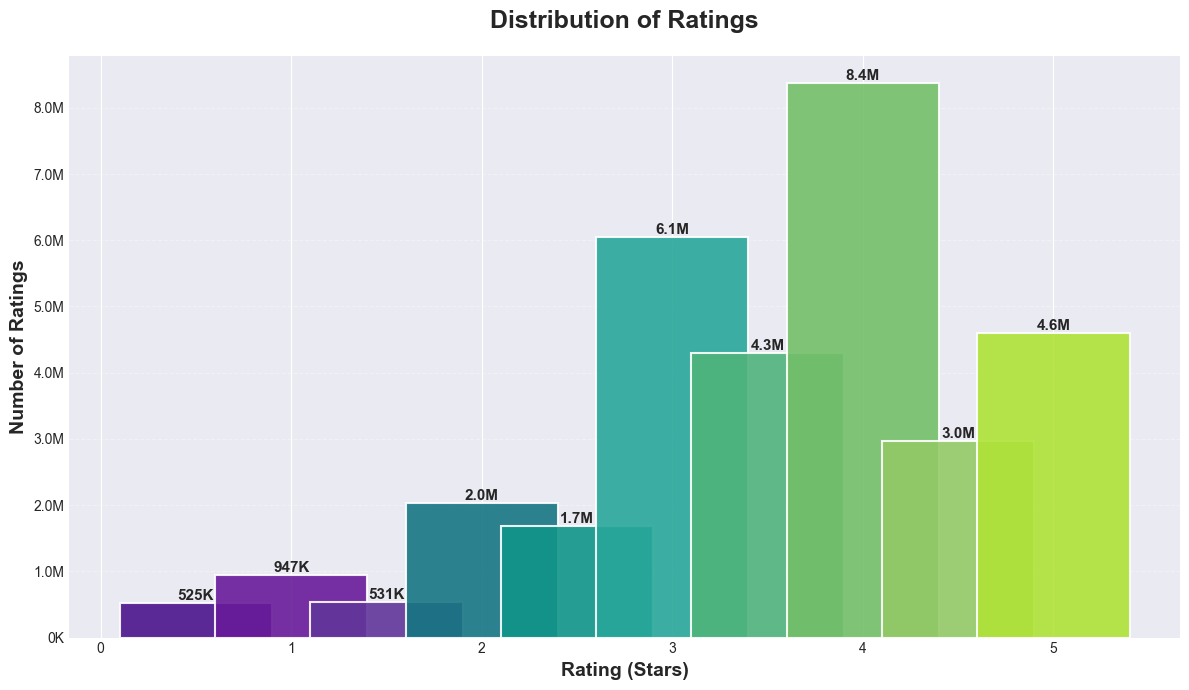

In [9]:
# 1. RATING DISTRIBUTION

fig, ax = plt.subplots(figsize=(12, 7))

rating_counts = ratings['rating'].value_counts().sort_index()

bars = ax.bar(rating_counts.index, rating_counts.values,
              color=[cmap_custom(i/len(rating_counts)) for i in range(len(rating_counts))],
              edgecolor='white', linewidth=1.5, alpha=0.9)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height/1e6:.1f}M' if height >= 1e6 else f'{height/1e3:.0f}K',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Rating (Stars)', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Ratings', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Ratings', fontsize=18, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))

plt.tight_layout()
plt.savefig('plots/01_rating_distribution.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

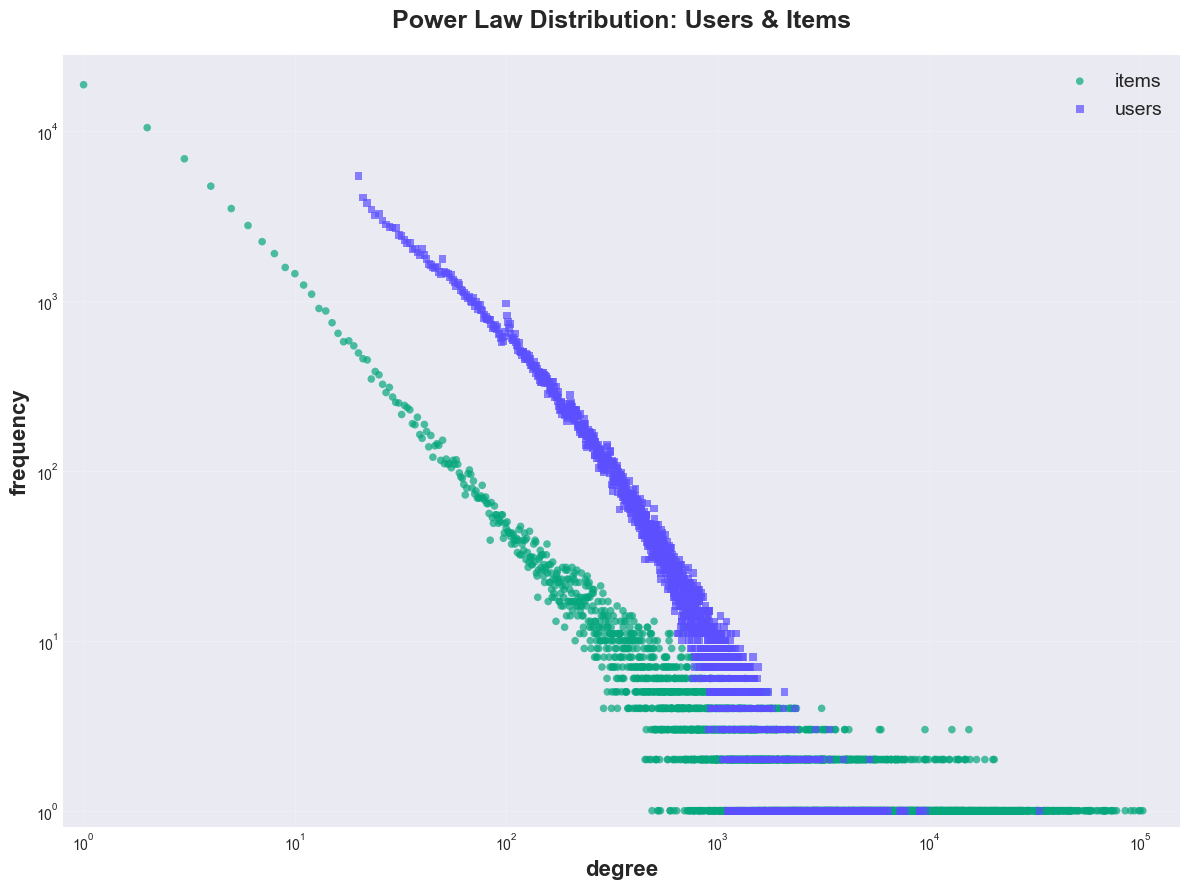

In [10]:
# 2. COMBINED POWER LAW (Users & Items)

user_counts = ratings['userId'].value_counts().values
movie_counts = ratings['movieId'].value_counts().values

fig, ax = plt.subplots(figsize=(12, 9))

user_degree_counts = Counter(user_counts)
user_degrees = np.array(sorted(user_degree_counts.keys()))
user_frequencies = np.array([user_degree_counts[d] for d in user_degrees])

# For movies (items)
movie_degree_counts = Counter(movie_counts)
movie_degrees = np.array(sorted(movie_degree_counts.keys()))
movie_frequencies = np.array([movie_degree_counts[d] for d in movie_degrees])

# Plot with scatter points
ax.scatter(movie_degrees, movie_frequencies,
           c='#06A77D', marker='o', s=30, alpha=0.7,
           label='items', edgecolors='none')
ax.scatter(user_degrees, user_frequencies,
           c='#5B4FFF', marker='s', s=30, alpha=0.7,
           label='users', edgecolors='none')

# Set log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('degree', fontsize=16, fontweight='bold')
ax.set_ylabel('frequency', fontsize=16, fontweight='bold')
ax.set_title('Power Law Distribution: Users & Items', fontsize=18, fontweight='bold', pad=20)

# Legend
ax.legend(fontsize=14, loc='upper right', framealpha=0.9)

# Grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Set axis limits for better visualization
ax.set_xlim(left=0.8, right=max(max(user_degrees), max(movie_degrees)) * 1.5)
ax.set_ylim(bottom=0.8, top=max(max(user_frequencies), max(movie_frequencies)) * 1.5)

plt.tight_layout()
plt.savefig('plots/02_combined_power_law.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

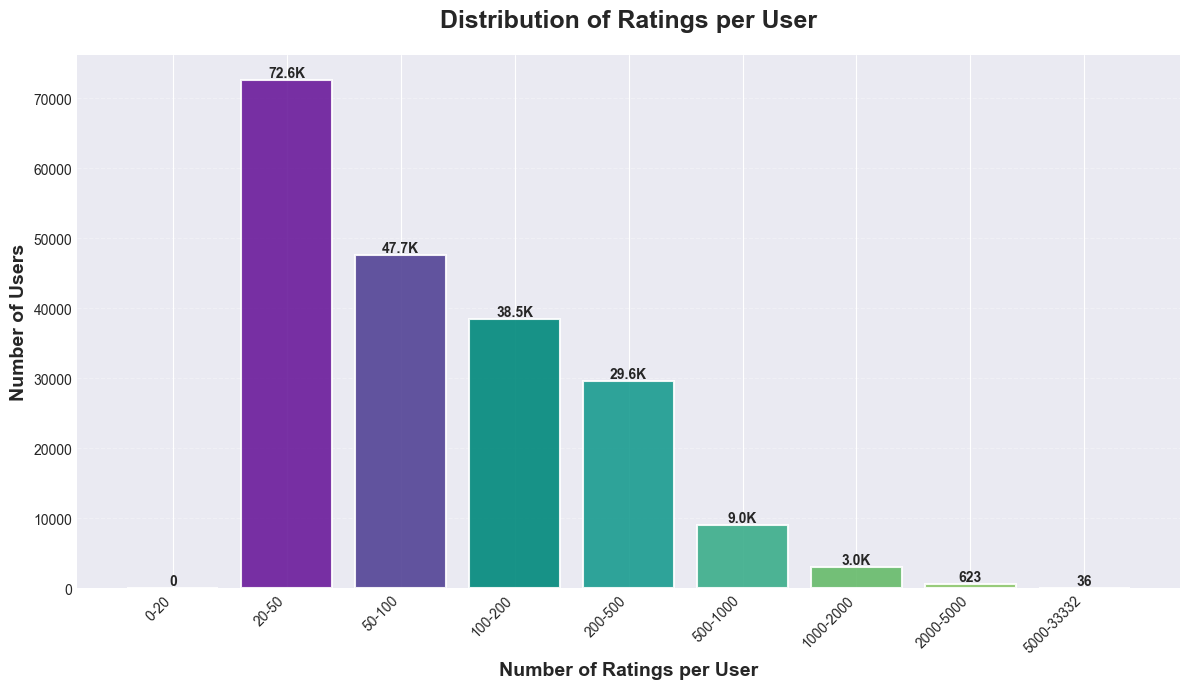

In [11]:
# 3. RATINGS PER USER DISTRIBUTION

fig, ax = plt.subplots(figsize=(12, 7))

bins = [0, 20, 50, 100, 200, 500, 1000, 2000, 5000, max(user_counts)]
hist, edges = np.histogram(user_counts, bins=bins)

x_pos = range(len(hist))
labels = [f'{int(edges[i])}-{int(edges[i+1])}' for i in range(len(edges)-1)]

bars = ax.bar(x_pos, hist, color=[cmap_custom(i/len(hist)) for i in range(len(hist))],
              edgecolor='white', linewidth=1.5, alpha=0.9)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height/1e3:.1f}K' if height >= 1e3 else f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Number of Ratings per User', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Users', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Ratings per User', fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('plots/03_ratings_per_user.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

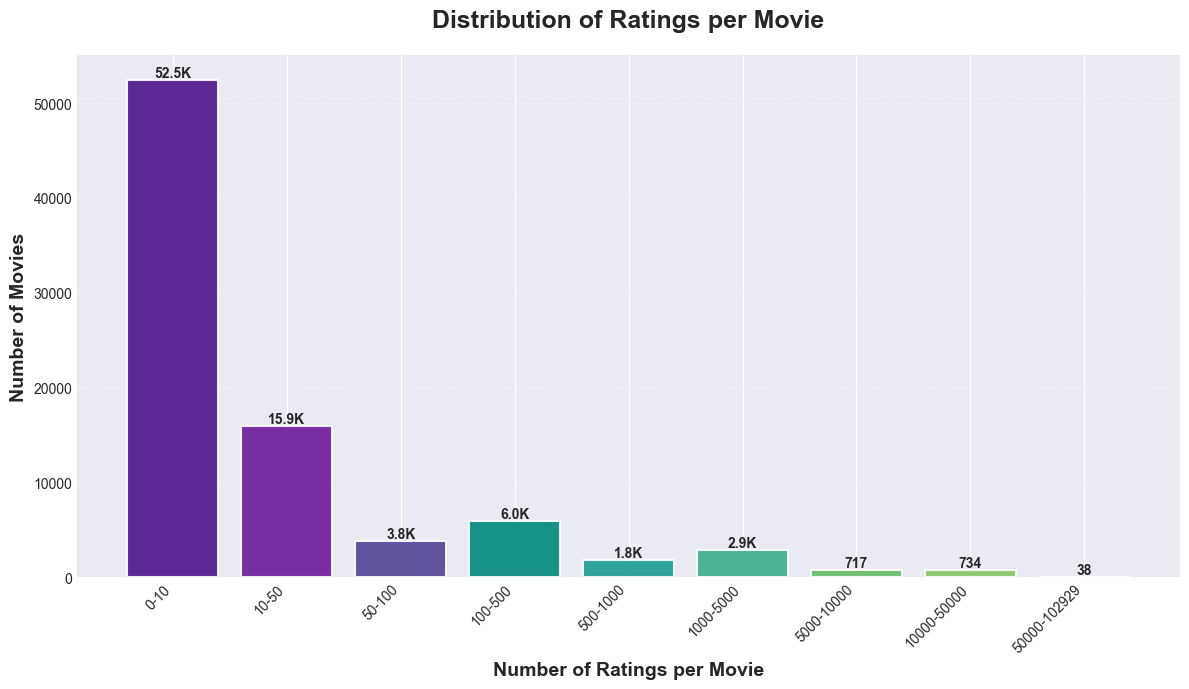

In [12]:
# 4. RATINGS PER MOVIE DISTRIBUTION

fig, ax = plt.subplots(figsize=(12, 7))

bins = [0, 10, 50, 100, 500, 1000, 5000, 10000, 50000, max(movie_counts)]
hist, edges = np.histogram(movie_counts, bins=bins)

x_pos = range(len(hist))
labels = [f'{int(edges[i])}-{int(edges[i+1])}' for i in range(len(edges)-1)]

bars = ax.bar(x_pos, hist, color=[cmap_custom(i/len(hist)) for i in range(len(hist))],
              edgecolor='white', linewidth=1.5, alpha=0.9)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height/1e3:.1f}K' if height >= 1e3 else f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Number of Ratings per Movie', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Movies', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Ratings per Movie', fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('plots/04_ratings_per_movie.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

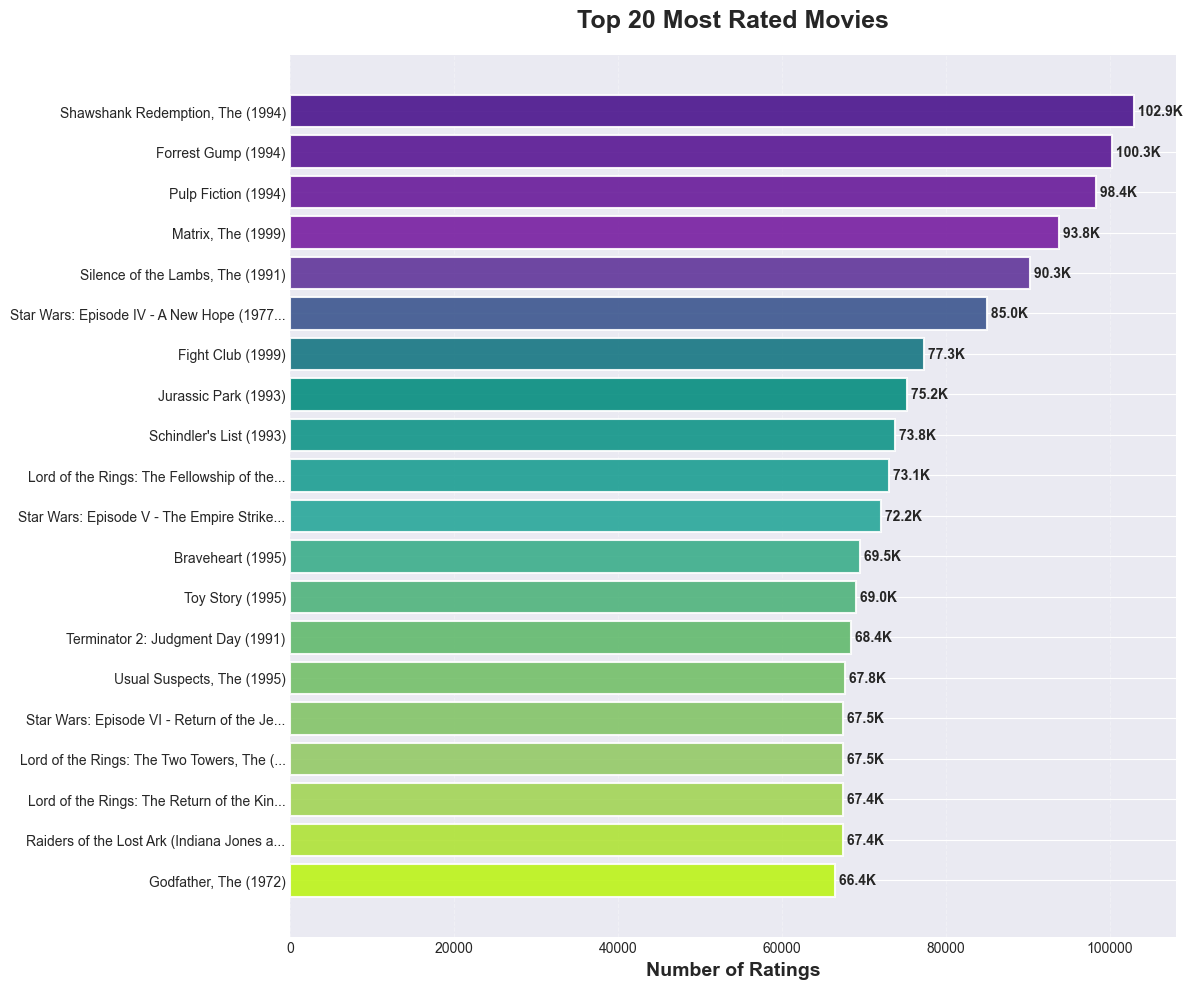

In [13]:
# 5. TOP 20 MOST RATED MOVIES

top_movies = ratings['movieId'].value_counts().head(20)
top_movie_info = movies[movies['movieId'].isin(top_movies.index)].set_index('movieId')

fig, ax = plt.subplots(figsize=(12, 10))

labels = [top_movie_info.loc[movie_id, 'title'][:40] + '...'
          if len(top_movie_info.loc[movie_id, 'title']) > 40
          else top_movie_info.loc[movie_id, 'title']
          for movie_id in top_movies.index]

y_pos = np.arange(len(labels))
colors = [cmap_custom(i/len(labels)) for i in range(len(labels))]

bars = ax.barh(y_pos, top_movies.values, color=colors,
               edgecolor='white', linewidth=1.5, alpha=0.9)

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f' {width/1e3:.1f}K',
            ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=10)
ax.set_xlabel('Number of Ratings', fontsize=14, fontweight='bold')
ax.set_title('Top 20 Most Rated Movies', fontsize=18, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('plots/05_top_20_movies.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

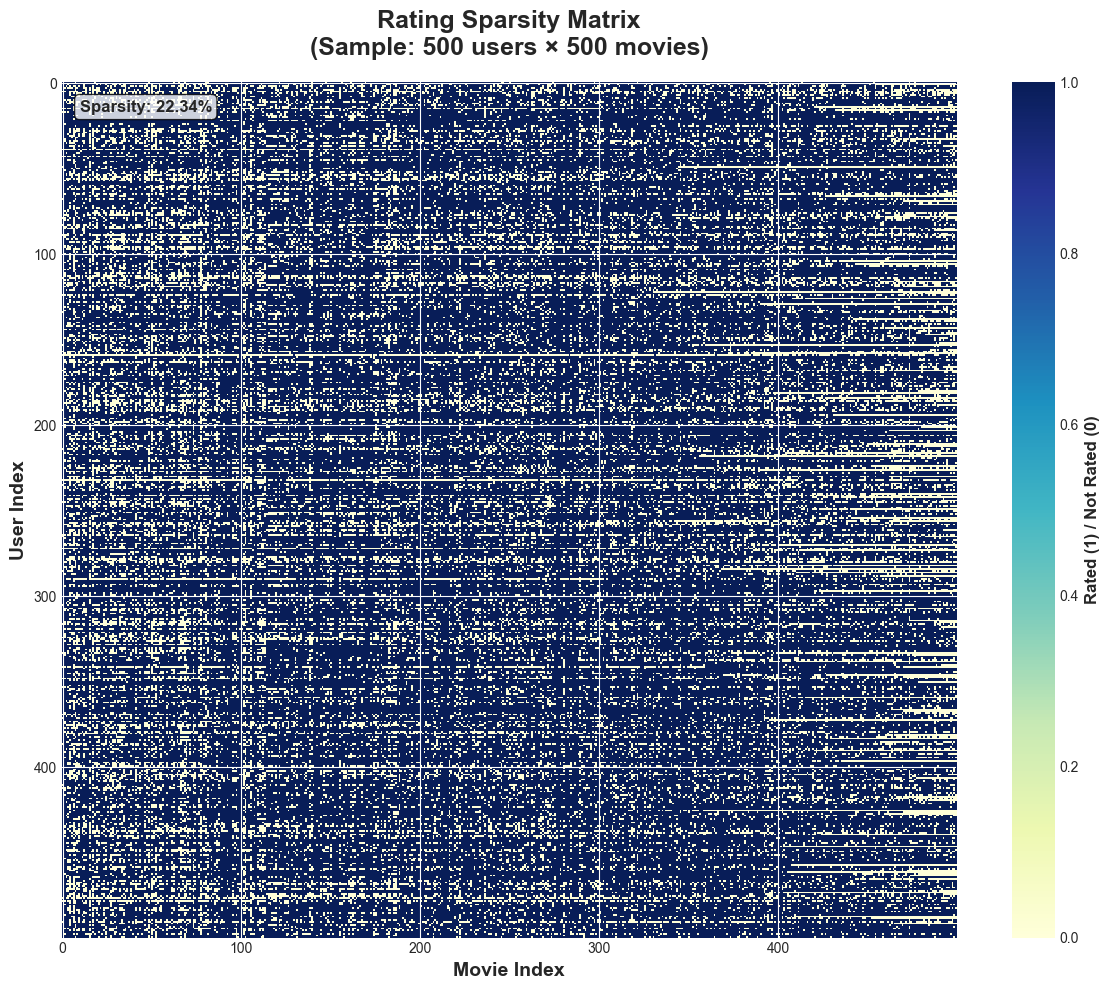

In [14]:
# 6. RATING SPARSITY MATRIX VISUALIZATION

n_users_sample = 500
n_movies_sample = 500

top_users = ratings['userId'].value_counts().head(n_users_sample).index
top_movies_ids = ratings['movieId'].value_counts().head(n_movies_sample).index

sample_data = ratings[ratings['userId'].isin(top_users) &
                      ratings['movieId'].isin(top_movies_ids)]

matrix = sample_data.pivot_table(index='userId', columns='movieId',
                                 values='rating', fill_value=0)

fig, ax = plt.subplots(figsize=(12, 10))

sparsity_matrix = (matrix > 0).astype(int)

im = ax.imshow(sparsity_matrix, cmap='YlGnBu', aspect='auto', interpolation='nearest')

ax.set_xlabel('Movie Index', fontsize=14, fontweight='bold')
ax.set_ylabel('User Index', fontsize=14, fontweight='bold')
ax.set_title(f'Rating Sparsity Matrix\n(Sample: {n_users_sample} users × {n_movies_sample} movies)',
             fontsize=18, fontweight='bold', pad=20)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Rated (1) / Not Rated (0)', fontsize=12, fontweight='bold')

sparsity = 100 * (1 - np.sum(sparsity_matrix.values) / sparsity_matrix.size)
ax.text(0.02, 0.98, f'Sparsity: {sparsity:.2f}%',
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('plots/06_sparsity_matrix.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

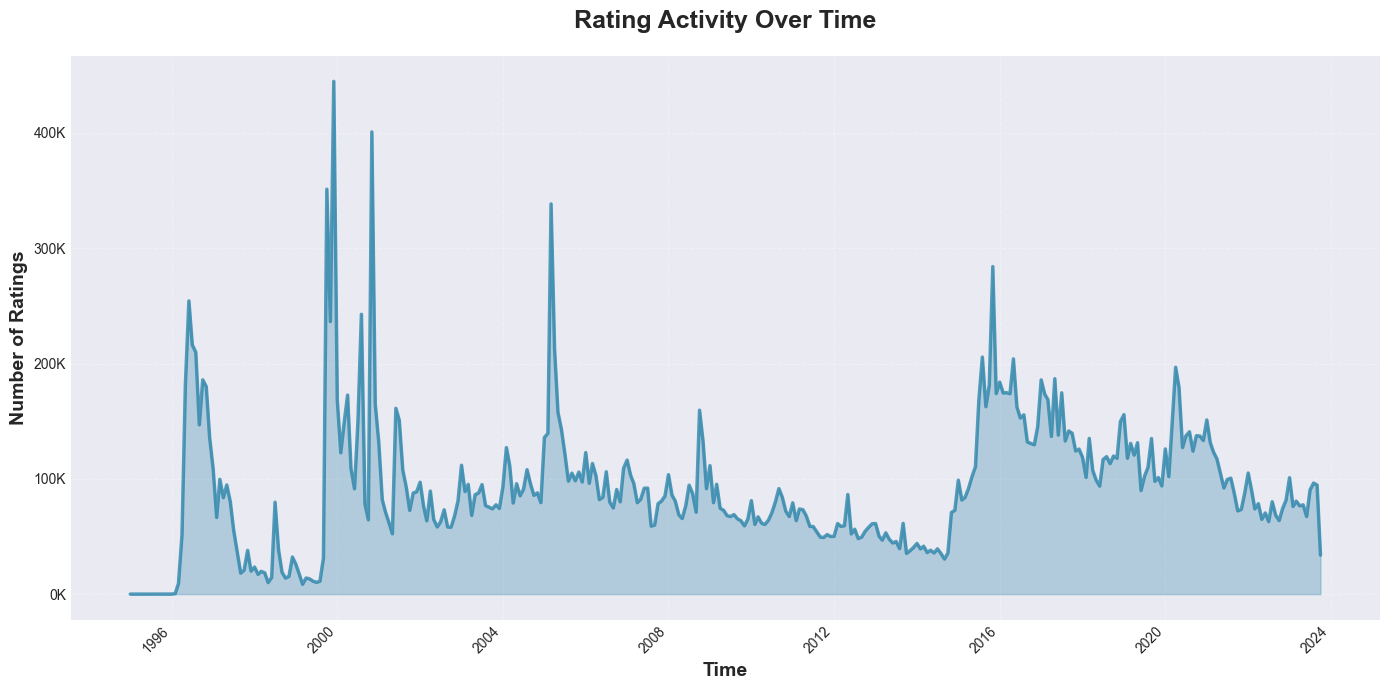

In [15]:
# 7. RATING ACTIVITY OVER TIME

ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year_month'] = ratings['datetime'].dt.to_period('M')

activity_over_time = ratings.groupby('year_month').size()

fig, ax = plt.subplots(figsize=(14, 7))

x_vals = activity_over_time.index.to_timestamp()
y_vals = activity_over_time.values

ax.plot(x_vals, y_vals, color=COLORS['primary'], linewidth=2.5, alpha=0.8)
ax.fill_between(x_vals, y_vals, alpha=0.3, color=COLORS['primary'])

ax.set_xlabel('Time', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Ratings', fontsize=14, fontweight='bold')
ax.set_title('Rating Activity Over Time', fontsize=18, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('plots/07_activity_over_time.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

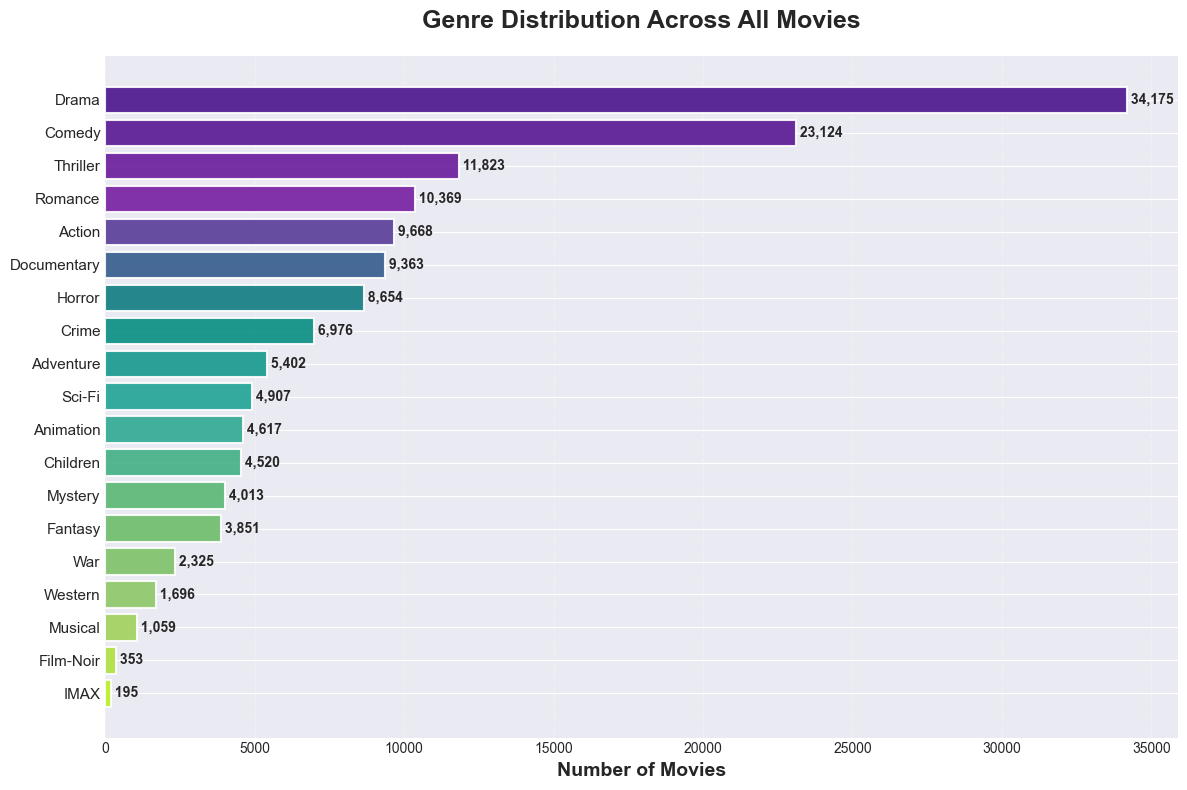

In [16]:
# 8. GENRE ANALYSIS

movies['genres_list'] = movies['genres'].str.split('|')
all_genres = []
for genres in movies['genres_list']:
    all_genres.extend(genres)

genre_counts = Counter(all_genres)

if '(no genres listed)' in genre_counts:
    del genre_counts['(no genres listed)']

genre_df = pd.DataFrame(genre_counts.most_common(), columns=['Genre', 'Count'])

fig, ax = plt.subplots(figsize=(12, 8))

colors = [cmap_custom(i/len(genre_df)) for i in range(len(genre_df))]
bars = ax.barh(range(len(genre_df)), genre_df['Count'], color=colors,
               edgecolor='white', linewidth=1.5, alpha=0.9)

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f' {width:,}',
            ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_yticks(range(len(genre_df)))
ax.set_yticklabels(genre_df['Genre'], fontsize=11)
ax.set_xlabel('Number of Movies', fontsize=14, fontweight='bold')
ax.set_title('Genre Distribution Across All Movies', fontsize=18, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('plots/08_genre_analysis.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Indexing Data_Structure

In [17]:
class IndexingStructure:
  def __init__(self, ratings):
    self.number_of_users = 0
    self.userid_to_idx  = {}
    self.idx_to_userid  = []
    self.data_by_user   = []

    self.number_of_movies = 0
    self.movieid_to_idx = {}
    self.idx_to_movieid = []
    self.data_by_movie  = []

    for rating in ratings:
      if not rating[0] in self.userid_to_idx:
        self.idx_to_userid.append(rating[0])
        self.userid_to_idx[rating[0]] = self.number_of_users
        self.number_of_users += 1
        self.data_by_user.append([])

      if not rating[1] in self.movieid_to_idx:
        self.idx_to_movieid.append(rating[1])
        self.movieid_to_idx[rating[1]] = self.number_of_movies
        self.number_of_movies += 1
        self.data_by_movie.append([])

      self.data_by_user[self.userid_to_idx[rating[0]]].append((self.movieid_to_idx[rating[1]],rating[2].item()))
      self.data_by_movie[self.movieid_to_idx[rating[1]]].append((self.userid_to_idx[rating[0]],rating[2].item()))


  # --------------------------------------------- Query Functions ---------------------------------------------------------- #

  def bin_search(self, array : list, value : int, key = lambda x:x):
    l = 0
    r = len(array)
    while r > l:
      m = (l+r)//2
      if value == key(array[m]):
        return m
      if value > key(array[m]):
        l = m+1
      else:
        r = m
    return -1

  def get_user_ratings(self, userid):
    if not userid in self.userid_to_idx:
      return 0, []
    user_ratings = self.data_by_user[self.userid_to_idx[userid]]
    n_ratings = len(user_ratings)
    return n_ratings, user_ratings

  def get_movie_ratings(self, movieid):
    if not movieid in self.movieid_to_idx:
      return 0, []
    movie_ratings = self.data_by_movie[self.movieid_to_idx[movieid]]
    n_ratings = len(movie_ratings)
    return n_ratings, movie_ratings

  def get_ratings(self, userid, movieid):
    if not (userid in self.userid_to_idx and movieid in self.movieid_to_idx):
      return 0
    movie_ratings = self.get_user_ratings(userid)[1]
    idx = self.bin_search(movie_ratings, self.movieid_to_idx[movieid], key = lambda x:x[0])
    return movie_ratings[idx][1]


# ----------------------------------------------- Train/ Test Split ----------------------------------------------------- #

  def split(self, split_ratio):

    self.data_by_user_train  = []
    self.data_by_user_test   = []
    self.data_by_movie_train = []
    self.data_by_movie_test  = []

    for user_ratings in self.data_by_user:
      self.data_by_user_train.append([])
      self.data_by_user_test.append([])

      for rating in user_ratings:
        u = np.random.random()
        if u < split_ratio:
          self.data_by_user_train[-1].append(rating)
        else:
          self.data_by_user_test[-1].append(rating)

    for movie_ratings in self.data_by_movie:
      self.data_by_movie_train.append([])
      self.data_by_movie_test.append([])

    for user_idx, user_ratings in enumerate(self.data_by_user_train):
      for rating in user_ratings:
        self.data_by_movie_train[rating[0]].append((user_idx, rating[1]))


    for user_idx, user_ratings in enumerate(self.data_by_user_test):
      for rating in user_ratings:
        self.data_by_movie_test[rating[0]].append((user_idx, rating[1]))


    self.number_of_users_train = len(self.data_by_user_train)
    self.number_of_movies_train = len(self.data_by_movie_train)
    self.number_of_users_test = len(self.data_by_user_test)
    self.number_of_movies_test = len(self.data_by_movie_test)

    print(f"number of users in train dataset:  {self.number_of_users_train}")
    print(f"number of movies in train dataset: {self.number_of_movies_train}")
    print()
    print(f"number of users in test dataset:  {self.number_of_users_test}")
    print(f"number of movies in test dataset: {self.number_of_movies_test}")
    print(end = '\n')


    ratings_in_train = 0
    for user_ratings in self.data_by_user_train:
      for rating in user_ratings:
        ratings_in_train += 1

    ratings_in_test = 0
    for user_ratings in self.data_by_user_test:
      for rating in user_ratings:
        ratings_in_test += 1

    print(f"number of ratings in train dataset: {ratings_in_train}")
    print(f"number of ratings in test dataset: {ratings_in_test}")
    ratio = ratings_in_train/(ratings_in_train + ratings_in_test)
    print(f"split ratio: {ratio:0.2f}")


  # -------------------------------------------- data_train functions ----------------------------------------------------------- #

  def get_user_ratings_train(self, userid):
    if not userid in self.userid_to_idx:
      return 0, []
    user_ratings = self.data_by_user_train[self.userid_to_idx[userid]]
    n_ratings = len(user_ratings)
    return n_ratings, user_ratings

  def get_movie_ratings_train(self, movieid):
    if not movieid in self.movieid_to_idx:
      return 0, []
    movie_ratings = self.data_by_movie_train[self.movieid_to_idx[movieid]]
    n_ratings = len(movie_ratings)
    return n_ratings, movie_ratings


  # -------------------------------------------- data_test functions ----------------------------------------------------------- #

  def get_user_ratings_test(self, userid):
    if not userid in self.userid_to_idx:
      return 0, []
    user_ratings = self.data_by_user_test[self.userid_to_idx[userid]]
    n_ratings = len(user_ratings)
    return n_ratings, user_ratings

  def get_movie_ratings_test(self, movieid):
    if not movieid in self.movieid_to_idx:
      return 0, []
    movie_ratings = self.data_by_movie_test[self.movieid_to_idx[movieid]]
    n_ratings = len(movie_ratings)
    return n_ratings, movie_ratings


## Indexing Initialization

In [18]:
ratings = np.loadtxt(
    "ratings.csv",
    delimiter=",",
    skiprows=1,
    usecols=(0, 1, 2)
)

print(ratings.shape)

(32000204, 3)


In [19]:
ratings_matrix = IndexingStructure(ratings)

### Query Functions

In [20]:
# Query user 1's ratings
n_ratings, user_ratings = ratings_matrix.get_user_ratings(1)
print(f"User 1 rated {n_ratings} movies")
print(user_ratings[:10])

# Query movie 1's ratings
n_ratings, movie_ratings = ratings_matrix.get_movie_ratings(1)
print(f"Movie 1 was rated by {n_ratings} users")
print(movie_ratings[:10])

# Get specific rating
rating = ratings_matrix.get_ratings(1, 17)
print(f"User 1's rating for movie 17: {rating}")

User 1 rated 141 movies
[(0, 4.0), (1, 1.0), (2, 2.0), (3, 5.0), (4, 5.0), (5, 2.0), (6, 1.0), (7, 5.0), (8, 3.0), (9, 5.0)]
Movie 1 was rated by 68997 users
[(9, 2.5), (10, 3.0), (16, 4.0), (18, 3.0), (19, 5.0), (22, 3.0), (23, 4.0), (27, 4.0), (32, 5.0), (33, 4.0)]
User 1's rating for movie 17: 4.0


# Practical 2:

## Train/ Test Split

In [21]:
ratings_matrix.split(0.9)

number of users in train dataset:  200948
number of movies in train dataset: 84432

number of users in test dataset:  200948
number of movies in test dataset: 84432

number of ratings in train dataset: 28798796
number of ratings in test dataset: 3201408
split ratio: 0.90


## Bias Only Optimization Model

### Training

In [22]:
user_biases = np.zeros(ratings_matrix.number_of_users)
movie_biases = np.zeros(ratings_matrix.number_of_movies)

lamda = 0.020393        
gamma = 0.001924           
iterations = 20

# For plotting
loss_history = []
rmse_history = []
rmse_test_history = []

for _ in range(iterations):
  for user_idx in range(ratings_matrix.number_of_users):
    bias = 0
    movie_counter = 0
    userid = ratings_matrix.idx_to_userid[user_idx]
    user_ratings = ratings_matrix.get_user_ratings_train(userid)[1]

    for movie_idx, rating in user_ratings:
      bias += lamda * (rating - movie_biases[movie_idx])
      movie_counter += 1
    if movie_counter > 0:
      bias = bias/(lamda * movie_counter + gamma)
      user_biases[user_idx] = bias


  for movie_idx in range(ratings_matrix.number_of_movies):
    bias = 0
    user_counter = 0
    movieid = ratings_matrix.idx_to_movieid[movie_idx]
    movie_ratings = ratings_matrix.get_movie_ratings_train(movieid)[1]

    for user_idx, rating in movie_ratings:
      bias += lamda * (rating - user_biases[user_idx])
      user_counter += 1
    if user_counter > 0:
      bias = bias/(lamda * user_counter + gamma)
      movie_biases[movie_idx] = bias

  loss_train = 0
  number_of_ratings_train = 0
  for user_idx, user_ratings in enumerate(ratings_matrix.data_by_user_train):
    for rating in user_ratings:
      pred = user_biases[user_idx] + movie_biases[rating[0]]
      r = rating[1]
      loss_train += (r - pred)**2
      number_of_ratings_train += 1
  rmse_train = np.sqrt(loss_train/number_of_ratings_train)

  loss_test = 0
  number_of_ratings_test = 0
  for user_idx, user_ratings in enumerate(ratings_matrix.data_by_user_test):
    for rating in user_ratings:
      pred = user_biases[user_idx] + movie_biases[rating[0]]
      r = rating[1]
      loss_test += (r - pred)**2
      number_of_ratings_test += 1
  rmse_test = np.sqrt(loss_test/number_of_ratings_test)

  print(f"Iteration {_+1}/{iterations}:\n "
      f"Train RMSE = {rmse_train:.4f}, Train Loss = {loss_train:.4f} \n "
      f"Test  RMSE = {rmse_test:.4f}, Test  Loss = {loss_test:.4f}\n")

  loss_history.append(loss_train)
  rmse_history.append(rmse_train)
  rmse_test_history.append(rmse_test)

# Print summary statistics
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Final Train RMSE: {rmse_history[-1]:.4f}")
print(f"Final Test RMSE:  {rmse_test_history[-1]:.4f}")
print(f"Train Improvement: {((rmse_history[0] - rmse_history[-1])/rmse_history[0]*100):.2f}%")
print(f"Test Improvement:  {((rmse_test_history[0] - rmse_test_history[-1])/rmse_test_history[0]*100):.2f}%")
print(f"Generalization Gap: {(rmse_test_history[-1] - rmse_history[-1]):.4f}")
print("="*60)


Iteration 1/20:
 Train RMSE = 0.8616, Train Loss = 21380270.3233 
 Test  RMSE = 0.8705, Test  Loss = 2426009.4498

Iteration 2/20:
 Train RMSE = 0.8470, Train Loss = 20659798.7633 
 Test  RMSE = 0.8560, Test  Loss = 2345560.6122

Iteration 3/20:
 Train RMSE = 0.8463, Train Loss = 20625083.4487 
 Test  RMSE = 0.8553, Test  Loss = 2341863.9924

Iteration 4/20:
 Train RMSE = 0.8462, Train Loss = 20622813.6920 
 Test  RMSE = 0.8552, Test  Loss = 2341654.5601

Iteration 5/20:
 Train RMSE = 0.8462, Train Loss = 20622550.6887 
 Test  RMSE = 0.8552, Test  Loss = 2341629.4599

Iteration 6/20:
 Train RMSE = 0.8462, Train Loss = 20622490.0577 
 Test  RMSE = 0.8552, Test  Loss = 2341618.2689

Iteration 7/20:
 Train RMSE = 0.8462, Train Loss = 20622469.2987 
 Test  RMSE = 0.8552, Test  Loss = 2341610.2583

Iteration 8/20:
 Train RMSE = 0.8462, Train Loss = 20622460.6016 
 Test  RMSE = 0.8552, Test  Loss = 2341603.7612

Iteration 9/20:
 Train RMSE = 0.8462, Train Loss = 20622456.3541 
 Test  RMSE = 

### Visualization

Saved: plots/bias_only_loss.pdf/png


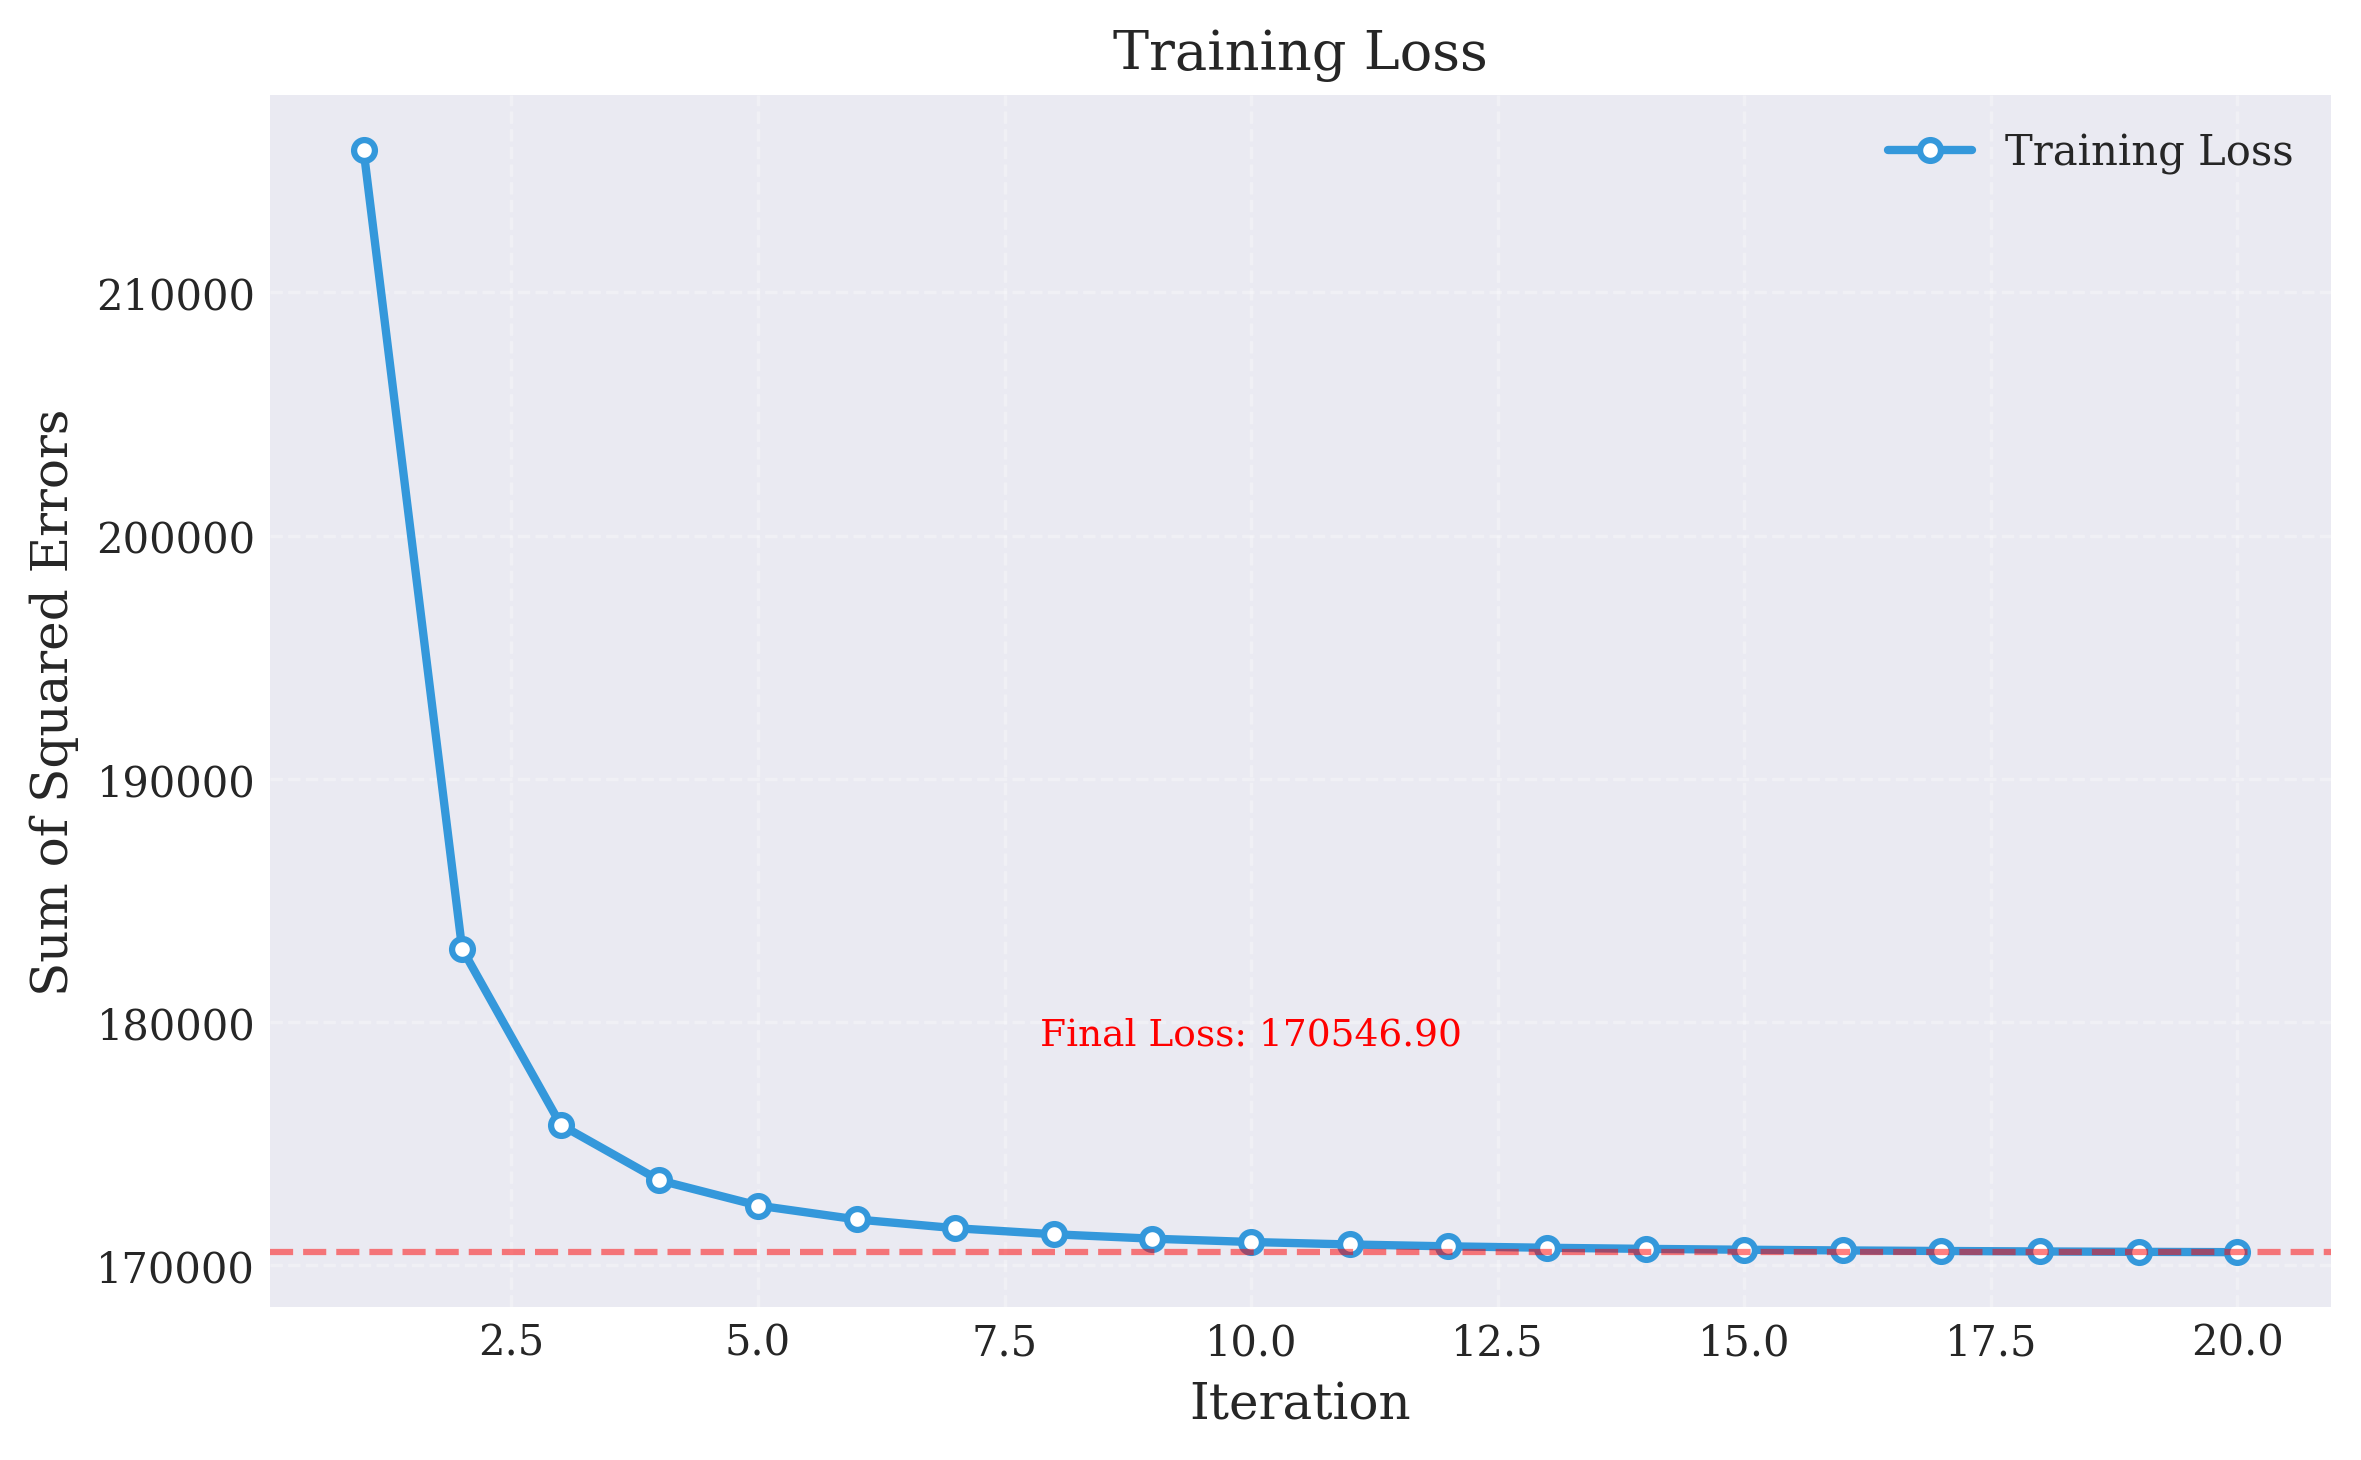

Saved: plots/bias_only_rmse.pdf/png


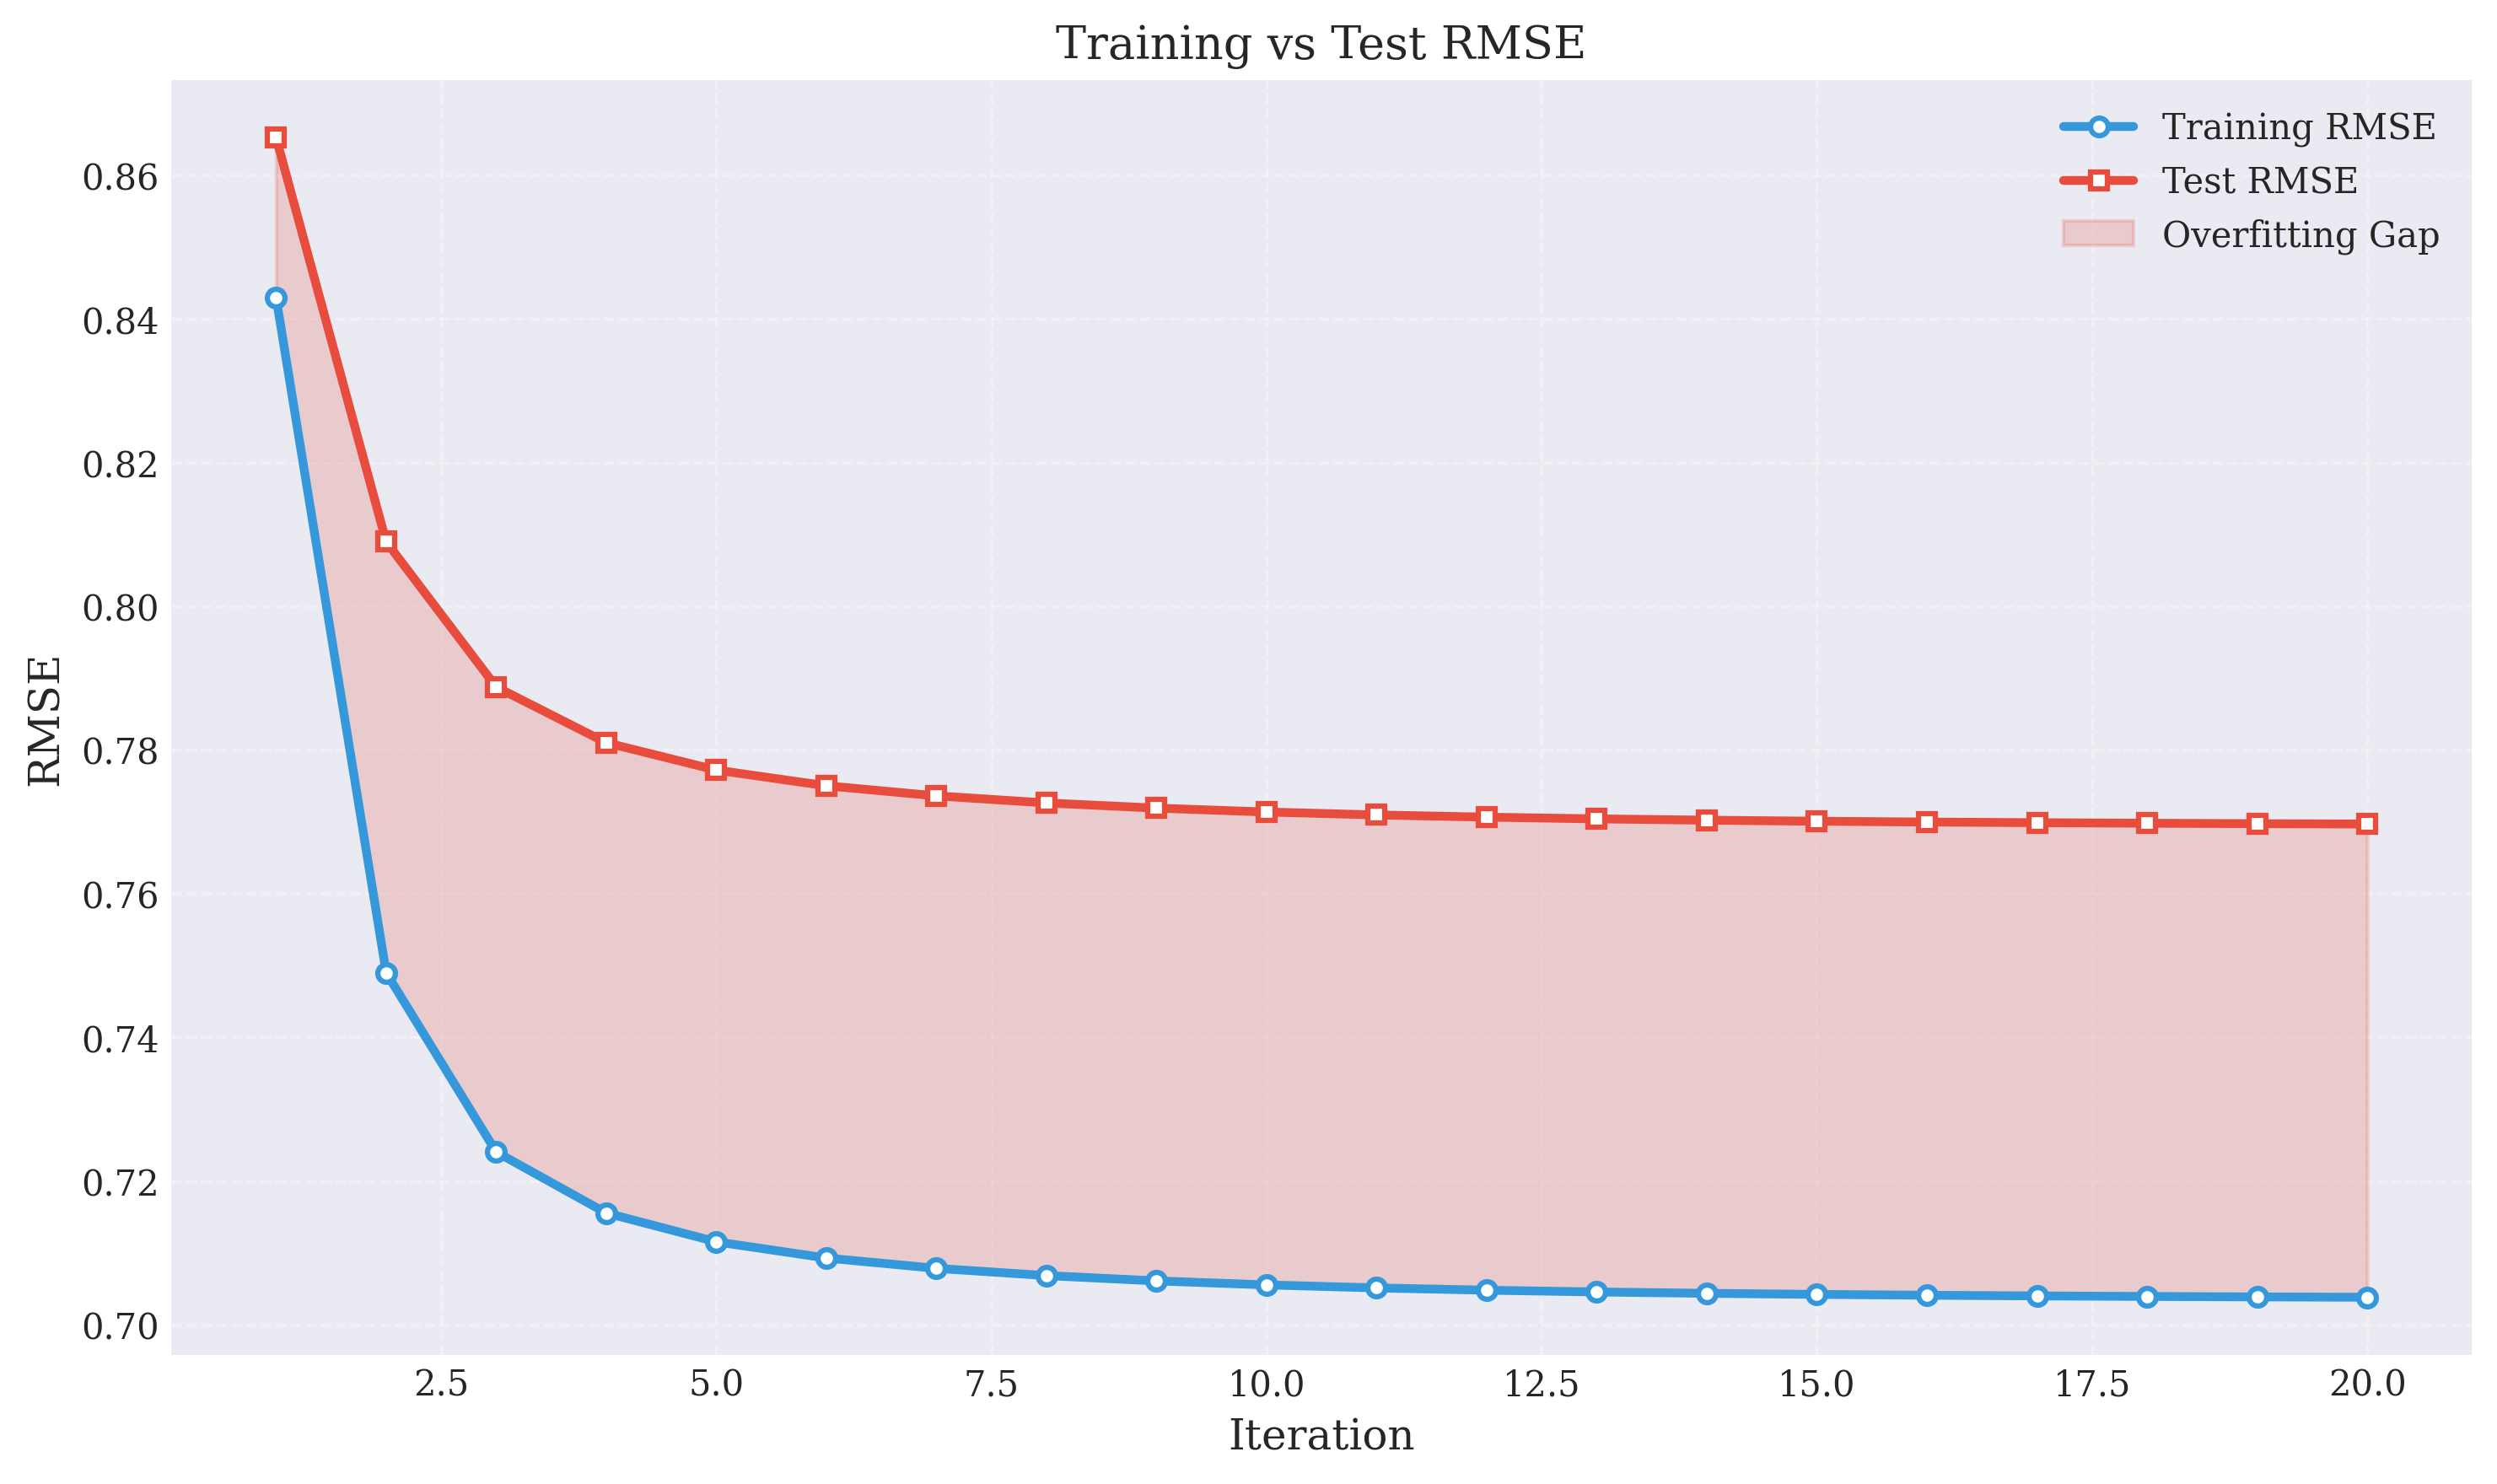


TRAINING SUMMARY
Total Iterations: 20

Final Training RMSE: 0.703800
Final Test RMSE: 0.769677
Overfitting Gap: 0.065877 (9.36%)

Best Test RMSE: 0.769677 (at iteration 20)
Improvement from first to last iteration: 0.095547


In [45]:
# Set publication-quality style
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'lines.linewidth': 2,
})

# FIGURE 1: Training Loss
fig, ax = plt.subplots(figsize=(8, 5))

iterations = np.arange(1, len(loss_history) + 1)
ax.plot(iterations, loss_history, marker='o', markersize=5, 
        color='#3498db', linewidth=2, markerfacecolor='white', 
        markeredgewidth=1.5, label='Training Loss')

ax.set_xlabel('Iteration')
ax.set_ylabel('Sum of Squared Errors')
ax.set_title('Training Loss')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend()

# Add convergence annotation if loss stabilizes
if len(loss_history) > 5:
    final_loss = loss_history[-1]
    ax.axhline(final_loss, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax.text(len(loss_history) * 0.5, final_loss * 1.05, 
            f'Final Loss: {final_loss:.2f}', 
            ha='center', fontsize=9, color='red')

plt.tight_layout()
plt.savefig('plots/bias_only_loss.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/bias_only_loss.png', format='png', dpi=300, bbox_inches='tight')
print("Saved: plots/bias_only_loss.pdf/png")
plt.show()
plt.close()

# FIGURE 2: Train vs Test RMSE with Overfitting Gap
fig, ax = plt.subplots(figsize=(10, 6))

iterations = np.arange(1, len(rmse_history) + 1)

# Plot training and test RMSE
train_line = ax.plot(iterations, rmse_history, marker='o', markersize=5, 
                     color='#3498db', linewidth=2.5, markerfacecolor='white',
                     markeredgewidth=1.5, label='Training RMSE')

test_line = ax.plot(iterations, rmse_test_history, marker='s', markersize=5,
                    color='#e74c3c', linewidth=2.5, markerfacecolor='white',
                    markeredgewidth=1.5, label='Test RMSE')

# Fill the overfitting gap
ax.fill_between(iterations, rmse_history, rmse_test_history, 
                where=(np.array(rmse_test_history) >= np.array(rmse_history)),
                alpha=0.2, color='#e74c3c', label='Overfitting Gap')

# Calculate and display final gap
final_train_rmse = rmse_history[-1]
final_test_rmse = rmse_test_history[-1]
gap = final_test_rmse - final_train_rmse
gap_percentage = (gap / final_train_rmse) * 100

ax.set_xlabel('Iteration')
ax.set_ylabel('RMSE')
ax.set_title('Training vs Test RMSE')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('plots/bias_only_rmse.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/bias_only_rmse.png', format='png', dpi=300, bbox_inches='tight')
print("Saved: plots/bias_only_rmse.pdf/png")
plt.show()
plt.close()

# Print Summary Statistics
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Total Iterations: {len(rmse_history)}")
print(f"\nFinal Training RMSE: {final_train_rmse:.6f}")
print(f"Final Test RMSE: {final_test_rmse:.6f}")
print(f"Overfitting Gap: {gap:.6f} ({gap_percentage:.2f}%)")
print(f"\nBest Test RMSE: {best_test_rmse:.6f} (at iteration {best_test_idx + 1})")
print(f"Improvement from first to last iteration: {rmse_test_history[0] - final_test_rmse:.6f}")
print("="*60)

# Practical 3:

##  Matrix Factorization with ALS Model

### Loss Function

In [24]:
def compute_loss(ratings_matrix, U, V, b_u, b_m, lamda, gamma_u, gamma_v, gamma_b, train=True):

    if train:
        data_by_user = ratings_matrix.data_by_user_train
    else:
        data_by_user = ratings_matrix.data_by_user_test

    # 1. Prediction error term
    squared_error = 0.0
    n_ratings = 0

    for user_idx, user_ratings in enumerate(data_by_user):
        for movie_idx, rating in user_ratings:
            # Prediction: u_u^T * v_m + b_u + b_m
            pred = np.dot(U[:,user_idx], V[:,movie_idx]) + b_u[user_idx] + b_m[movie_idx]

            # Squared error
            error = rating - pred
            squared_error += error ** 2
            n_ratings += 1


    # 2. Regularization terms
    # User embedding regularization
    user_embedding_reg = np.sum(U ** 2)

    # Movie embedding regularization
    movie_embedding_reg = np.sum(V ** 2)

    # Bias regularization
    user_bias_reg = np.sum(b_u ** 2)
    movie_bias_reg = np.sum(b_m ** 2)

    # 3. Full loss
    loss =(lamda / 2) * squared_error + \
          (gamma_u / 2) * user_embedding_reg + \
          (gamma_v / 2) * movie_embedding_reg + \
          (gamma_b / 2) * (user_bias_reg + movie_bias_reg)


    # 4. RMSE
    rmse = np.sqrt(squared_error / n_ratings) if n_ratings > 0 else 0.0

    return loss, rmse


### Training

In [25]:
user_biases = np.zeros((ratings_matrix.number_of_users))
movie_biases = np.zeros((ratings_matrix.number_of_movies))

k = 20
user_embeddings = np.random.normal(0, 0.1, size=(k, ratings_matrix.number_of_users))
movie_embeddings = np.random.normal(0, 0.1, size=(k, ratings_matrix.number_of_movies))

# Hyperparameters

lamda = 0.02039307537342147
gamma_u = 0.8587551700375037
gamma_v = 0.8034116286188123
gamma_b = 0.00192377578961482
iterations = 20

# For plotting
loss_history = []
rmse_history = []
rmse_test_history = []

for _ in range(iterations):
  for user_idx in range(ratings_matrix.number_of_users):
    bias = 0
    userid = ratings_matrix.idx_to_userid[user_idx]
    n_ratings, user_ratings = ratings_matrix.get_user_ratings_train(userid)
    if n_ratings == 0:
            continue
    # user bias update
    for movie_idx, rating in user_ratings:
      bias += lamda * (rating - movie_biases[movie_idx]- np.dot(user_embeddings[:,user_idx], movie_embeddings[:,movie_idx]))
    bias = bias/(lamda * n_ratings + gamma_b)
    user_biases[user_idx] = bias

    # user embedding update
    first_term = gamma_u * np.eye(movie_embeddings.shape[0])
    second_term = np.zeros(movie_embeddings.shape[0])
    for movie_idx, rating in user_ratings:
      v_n = movie_embeddings[:,movie_idx]
      first_term += lamda * np.outer(v_n, v_n)
      second_term += lamda * v_n * (rating - user_biases[user_idx] - movie_biases[movie_idx])
    # solving for u_m
    try:
      user_embeddings[:,user_idx] = np.linalg.solve(first_term, second_term)
    except np.linalg.LinAlgError:
      user_embeddings[:,user_idx] = np.linalg.lstsq(first_term, second_term, rcond=None)[0]

  for movie_idx in range(ratings_matrix.number_of_movies):
    bias = 0
    movieid = ratings_matrix.idx_to_movieid[movie_idx]
    m_ratings, movie_ratings = ratings_matrix.get_movie_ratings_train(movieid)
    if m_ratings == 0:
            continue

    for user_idx, rating in movie_ratings:
      bias += lamda * (rating - user_biases[user_idx]- np.dot(user_embeddings[:,user_idx], movie_embeddings[:,movie_idx]))
    bias = bias/(lamda * m_ratings + gamma_b)
    movie_biases[movie_idx] = bias

    first_term = gamma_v * np.eye(user_embeddings.shape[0])
    second_term = np.zeros(user_embeddings.shape[0])
    for user_idx, rating in movie_ratings:
      u_m = user_embeddings[:,user_idx]
      second_term += lamda * (u_m * (rating - user_biases[user_idx] - movie_biases[movie_idx]))
      first_term += lamda * np.outer(u_m, u_m)
    # solving for v_n
    try:
      movie_embeddings[:,movie_idx] = np.linalg.solve(first_term, second_term)
    except np.linalg.LinAlgError:
      movie_embeddings[:,movie_idx] = np.linalg.lstsq(first_term, second_term, rcond=None)[0]



  loss_train, rmse_train = compute_loss(ratings_matrix, user_embeddings, movie_embeddings, user_biases, movie_biases, lamda, gamma_u, gamma_v, gamma_b, train=True)
  loss_test, rmse_test = compute_loss(ratings_matrix, user_embeddings, movie_embeddings, user_biases, movie_biases, lamda, gamma_u, gamma_v, gamma_b, train=False)

  print(f"Iteration {_+1}/{iterations}:\n "
      f"Train RMSE = {rmse_train:.4f}, Train Loss = {loss_train:.4f} \n "
      f"Test  RMSE = {rmse_test:.4f}, Test  Loss = {loss_test:.4f}\n")

  loss_history.append(loss_train)
  rmse_history.append(rmse_train)
  rmse_test_history.append(rmse_test)

# Print summary statistics
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Final Train RMSE: {rmse_history[-1]:.4f}")
print(f"Final Test RMSE:  {rmse_test_history[-1]:.4f}")
print(f"Train Improvement: {((rmse_history[0] - rmse_history[-1])/rmse_history[0]*100):.2f}%")
print(f"Test Improvement:  {((rmse_test_history[0] - rmse_test_history[-1])/rmse_test_history[0]*100):.2f}%")
print(f"Generalization Gap: {(rmse_test_history[-1] - rmse_history[-1]):.4f}")
print("="*60)


Iteration 1/20:
 Train RMSE = 0.8430, Train Loss = 215859.1062 
 Test  RMSE = 0.8652, Test  Loss = 31639.9409

Iteration 2/20:
 Train RMSE = 0.7490, Train Loss = 183009.6053 
 Test  RMSE = 0.8090, Test  Loss = 39645.7377

Iteration 3/20:
 Train RMSE = 0.7240, Train Loss = 175781.0163 
 Test  RMSE = 0.7888, Test  Loss = 42156.8397

Iteration 4/20:
 Train RMSE = 0.7155, Train Loss = 173499.9633 
 Test  RMSE = 0.7810, Test  Loss = 43068.7189

Iteration 5/20:
 Train RMSE = 0.7115, Train Loss = 172462.8172 
 Test  RMSE = 0.7772, Test  Loss = 43517.7588

Iteration 6/20:
 Train RMSE = 0.7093, Train Loss = 171891.9014 
 Test  RMSE = 0.7750, Test  Loss = 43776.9618

Iteration 7/20:
 Train RMSE = 0.7078, Train Loss = 171532.3082 
 Test  RMSE = 0.7736, Test  Loss = 43945.3210

Iteration 8/20:
 Train RMSE = 0.7068, Train Loss = 171282.9521 
 Test  RMSE = 0.7726, Test  Loss = 44064.4747

Iteration 9/20:
 Train RMSE = 0.7061, Train Loss = 171100.7935 
 Test  RMSE = 0.7719, Test  Loss = 44153.0711

I

### Visualization

Saved: plots/embeddings_loss.pdf/png


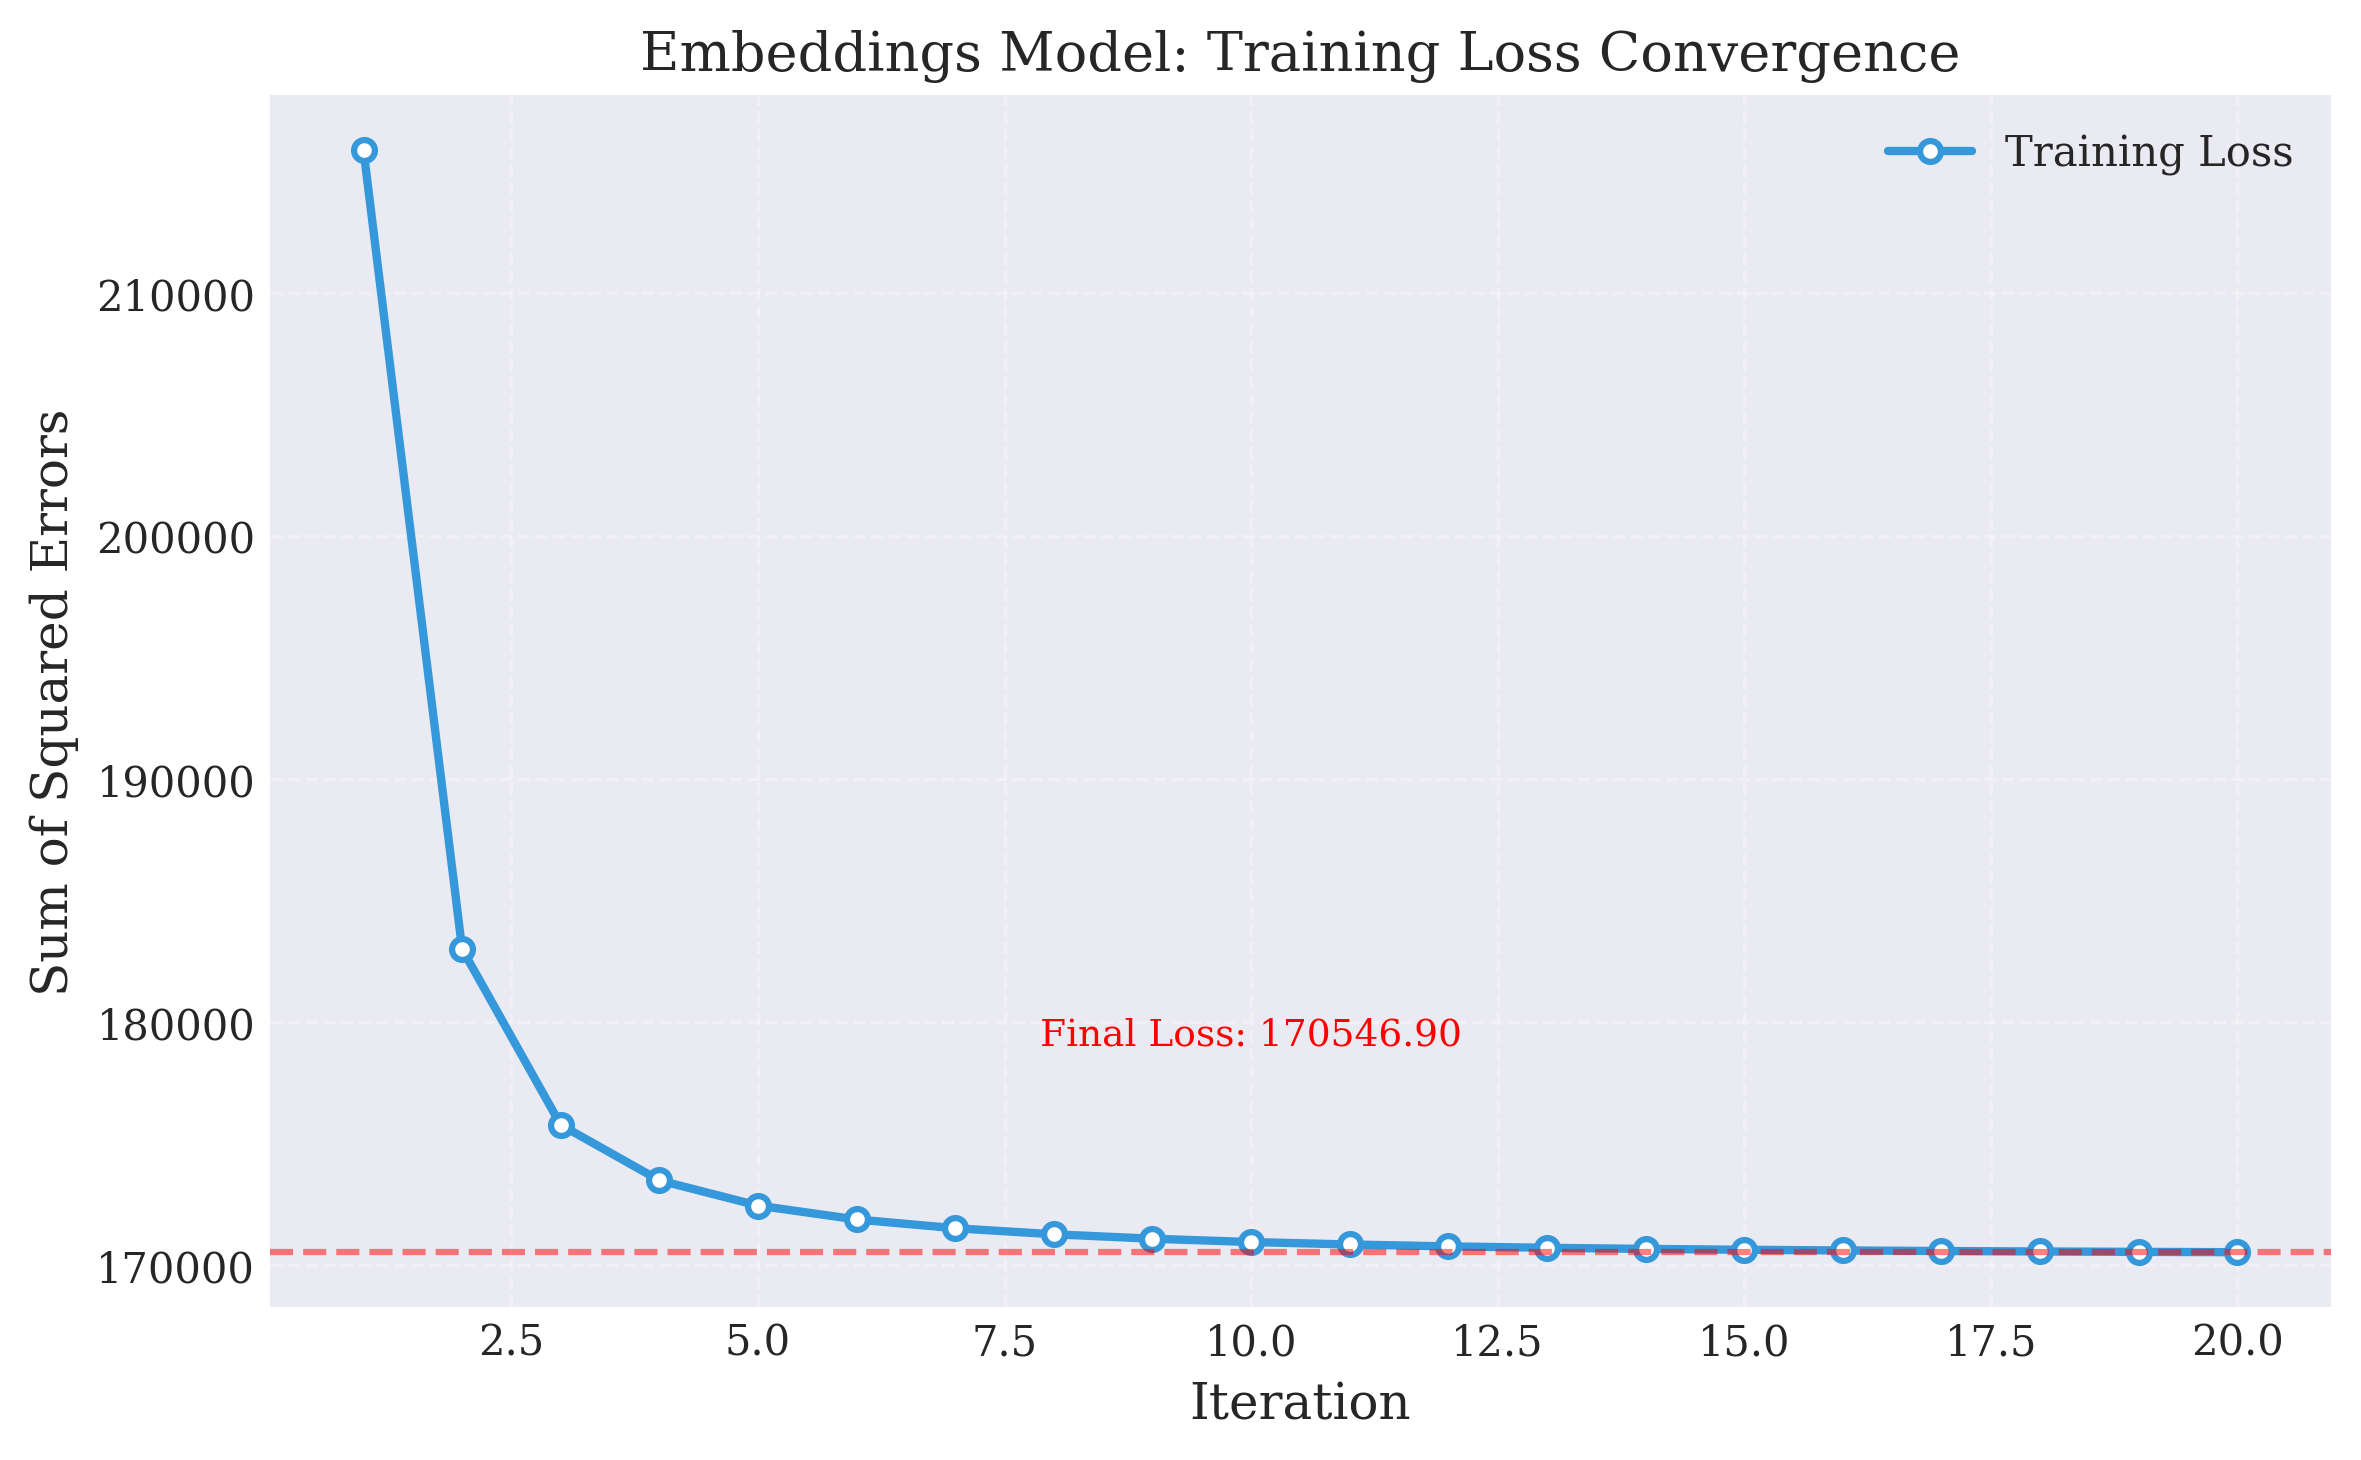

Saved: plots/embeddings_rmse.pdf/png


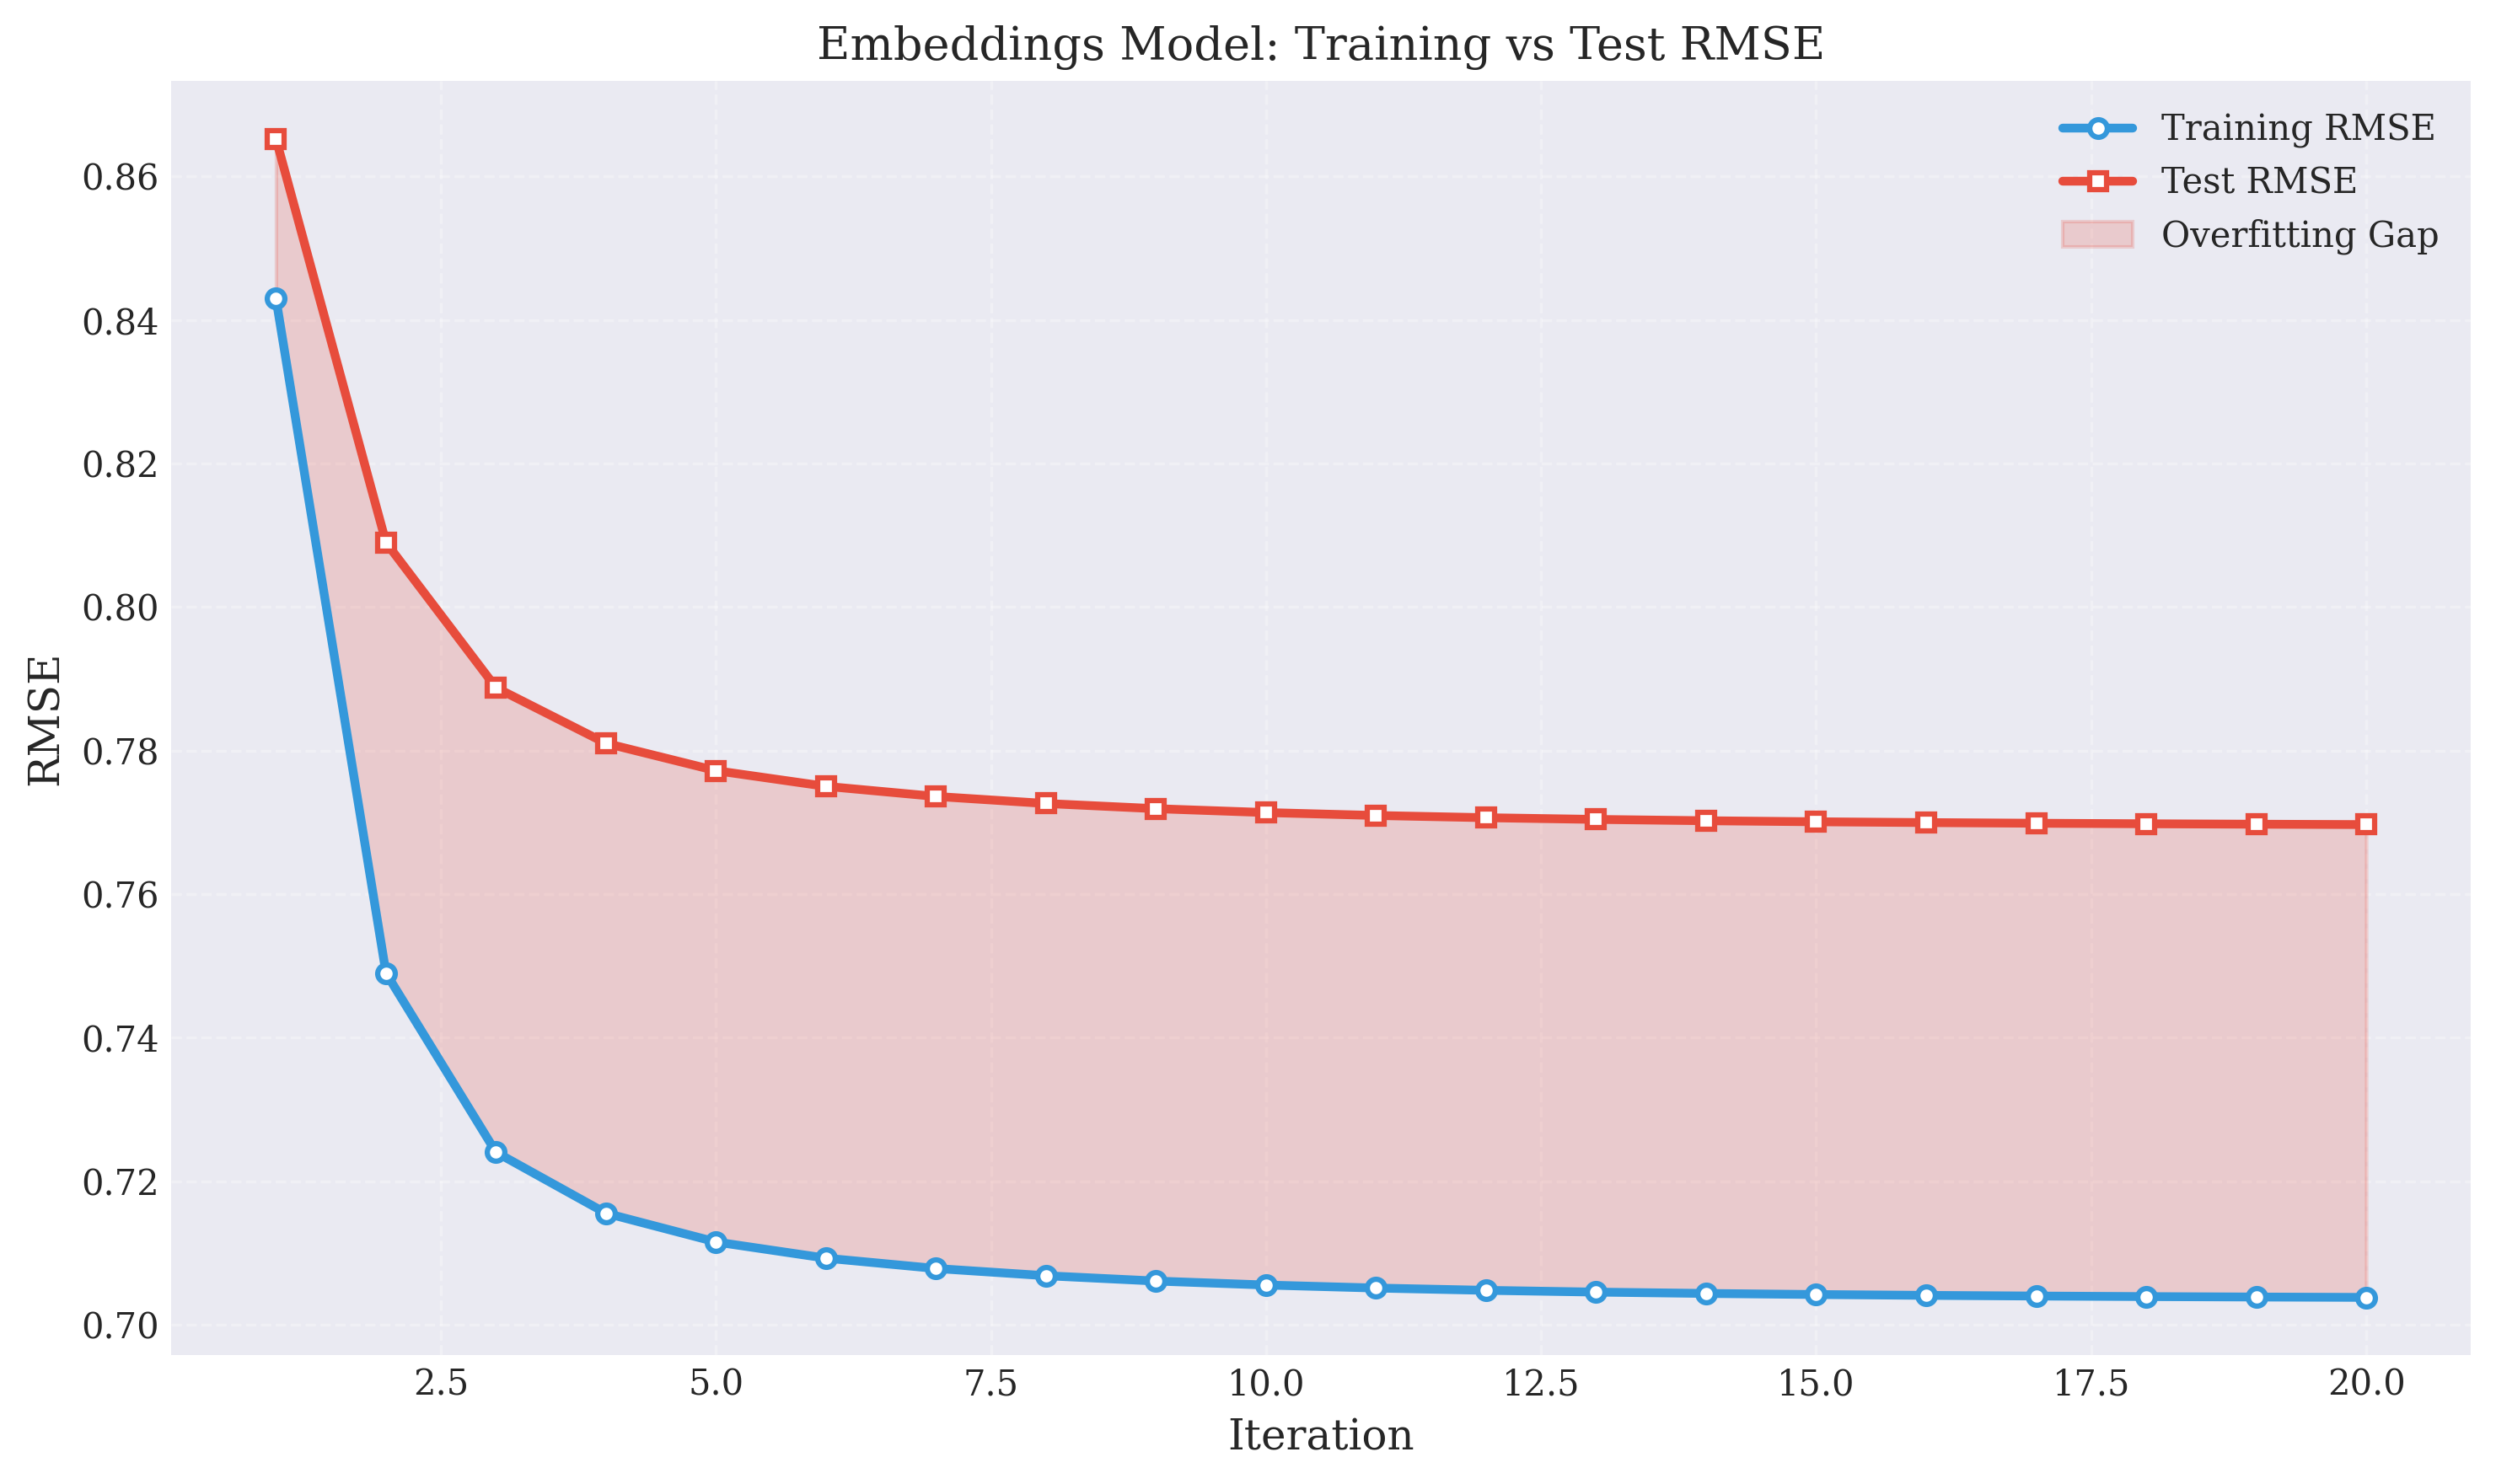


EMBEDDINGS MODEL: TRAINING SUMMARY
Total Iterations: 20

Final Training RMSE: 0.703800
Final Test RMSE: 0.769677
Overfitting Gap: 0.065877 (9.36%)

Best Test RMSE: 0.769677 (at iteration 20)
Improvement from first to last iteration: 0.095547
Average improvement per iteration: 0.004777


In [46]:
# Set publication-quality style
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'lines.linewidth': 2,
})

# FIGURE 1: Training Loss

fig, ax = plt.subplots(figsize=(8, 5))

iterations = np.arange(1, len(loss_history) + 1)
ax.plot(iterations, loss_history, marker='o', markersize=5, 
        color='#3498db', linewidth=2, markerfacecolor='white', 
        markeredgewidth=1.5, label='Training Loss')

ax.set_xlabel('Iteration')
ax.set_ylabel('Sum of Squared Errors')
ax.set_title('Embeddings Model: Training Loss Convergence')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend()

# Add convergence annotation if loss stabilizes
if len(loss_history) > 5:
    final_loss = loss_history[-1]
    ax.axhline(final_loss, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax.text(len(loss_history) * 0.5, final_loss * 1.05, 
            f'Final Loss: {final_loss:.2f}', 
            ha='center', fontsize=9, color='red')

plt.tight_layout()
plt.savefig('plots/embeddings_loss.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/embeddings_loss.png', format='png', dpi=300, bbox_inches='tight')
print("Saved: plots/embeddings_loss.pdf/png")
plt.show()
plt.close()

# FIGURE 2: Train vs Test RMSE with Overfitting Gap
fig, ax = plt.subplots(figsize=(10, 6))

iterations = np.arange(1, len(rmse_history) + 1)

# Plot training and test RMSE
train_line = ax.plot(iterations, rmse_history, marker='o', markersize=5, 
                     color='#3498db', linewidth=2.5, markerfacecolor='white',
                     markeredgewidth=1.5, label='Training RMSE')

test_line = ax.plot(iterations, rmse_test_history, marker='s', markersize=5,
                    color='#e74c3c', linewidth=2.5, markerfacecolor='white',
                    markeredgewidth=1.5, label='Test RMSE')

# Fill the overfitting gap
ax.fill_between(iterations, rmse_history, rmse_test_history, 
                where=(np.array(rmse_test_history) >= np.array(rmse_history)),
                alpha=0.2, color='#e74c3c', label='Overfitting Gap')


ax.set_xlabel('Iteration')
ax.set_ylabel('RMSE')
ax.set_title('Embeddings Model: Training vs Test RMSE')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('plots/embeddings_rmse.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/embeddings_rmse.png', format='png', dpi=300, bbox_inches='tight')
print("Saved: plots/embeddings_rmse.pdf/png")
plt.show()
plt.close()

# Print Summary Statistics
print("\n" + "="*60)
print("EMBEDDINGS MODEL: TRAINING SUMMARY")
print("="*60)
print(f"Total Iterations: {len(rmse_history)}")
print(f"\nFinal Training RMSE: {final_train_rmse:.6f}")
print(f"Final Test RMSE: {final_test_rmse:.6f}")
print(f"Overfitting Gap: {gap:.6f} ({gap_percentage:.2f}%)")
print(f"\nBest Test RMSE: {best_test_rmse:.6f} (at iteration {best_test_idx + 1})")
print(f"Improvement from first to last iteration: {rmse_test_history[0] - final_test_rmse:.6f}")

# Calculate average improvement per iteration
avg_improvement = (rmse_test_history[0] - final_test_rmse) / len(rmse_test_history)
print(f"Average improvement per iteration: {avg_improvement:.6f}")

print("="*60)

# Practical 4:

## Qualitative Evaluation (Dummy User)

In [28]:
df2 = pd.read_csv('movies.csv')
df2.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [29]:
def dummy_user_train(dummy_user_ratings, movie_embeddings, movie_biases, lamda, gamma_u, gamma_b, k = 10, iterations=10):
    dummy_user_embedding = np.random.normal(0, 0.1, size=(k,))
    dummy_bias = 0
    n_ratings = len(dummy_user_ratings)

    for _ in range(iterations):
        # Update bias in each iteration
        bias_sum = 0
        for movie_idx, rating in dummy_user_ratings:
            pred = movie_biases[movie_idx] + np.dot(dummy_user_embedding, movie_embeddings[:, movie_idx])
            bias_sum += lamda * (rating - pred)
        dummy_bias = bias_sum / (lamda * n_ratings + gamma_b)

        # Update embedding
        first_term = gamma_u * np.eye(k)
        second_term = np.zeros(k)

        for movie_idx, rating in dummy_user_ratings:
            v_n = movie_embeddings[:, movie_idx]
            first_term += lamda * np.outer(v_n, v_n)
            second_term += lamda * v_n * (rating - dummy_bias - movie_biases[movie_idx])

        try:
            dummy_user_embedding = np.linalg.solve(first_term, second_term)
        except np.linalg.LinAlgError:
            dummy_user_embedding = np.linalg.lstsq(first_term, second_term, rcond=None)[0]

    return dummy_user_embedding, dummy_bias

In [30]:
def dummy_user_recommendation(dummy_user_embedding, movie_embeddings,dummy_bias, movie_biases):
  score = np.zeros(movie_embeddings.shape[1])
  for movie_idx in range(movie_embeddings.shape[1]):
    n_ratings = ratings_matrix.get_movie_ratings(movie_idx)[0]
    # Calculate score
    if n_ratings < 100:
      score[movie_idx] = 0
    else:
      score[movie_idx] = (np.dot(dummy_user_embedding, movie_embeddings[:, movie_idx]) + movie_biases[movie_idx]* 0.05)

  ranked_items =  np.argsort(score)[::-1]

  return score, ranked_items

In [50]:
dummy_movie_ids = [4896]
dummy_ratings = [5.0]
dummy_movie_idx = []
dummy_user_ratings = []
n_rec = 20

for id, rating in zip(dummy_movie_ids, dummy_ratings):
    mov_idx = ratings_matrix.movieid_to_idx[id]
    dummy_movie_idx.append(mov_idx)
    dummy_user_ratings.append((mov_idx, rating))

dummy_user_embidding, dummy_bias = dummy_user_train(dummy_user_ratings,
                                        movie_embeddings,
                                        movie_biases,
                                        lamda = lamda,
                                        gamma_u = gamma_u,
                                        gamma_b = gamma_b,
                                        k = k,
                                        iterations = 10
)
score, ranked_items = dummy_user_recommendation(dummy_user_embidding, movie_embeddings, dummy_bias, movie_biases)
# print(ranked_items[10:50], score[10:50], sep = '\n')


top_recommendations = []
# Filter out movies the user has already rated
for i in range(len(ranked_items)):
    if ranked_items[i] not in dummy_movie_idx:
        top_recommendations.append(ranked_items[i])
    if len(top_recommendations) >= n_rec:
        break


for i in range(len(top_recommendations)):
    recommendation_id = ratings_matrix.idx_to_movieid[top_recommendations[i]]
    row = df2[df2['movieId'] == recommendation_id][['title','genres']].values[0]
    print(*list(row))






Harry Potter and the Prisoner of Azkaban (2004) Adventure|Fantasy|IMAX
Harry Potter and the Chamber of Secrets (2002) Adventure|Fantasy
Harry Potter and the Half-Blood Prince (2009) Adventure|Fantasy|Mystery|Romance|IMAX
Harry Potter and the Deathly Hallows: Part 2 (2011) Action|Adventure|Drama|Fantasy|Mystery|IMAX
Harry Potter and the Deathly Hallows: Part 1 (2010) Action|Adventure|Fantasy|IMAX
Star Wars: Episode I - The Phantom Menace (1999) Action|Adventure|Sci-Fi
Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy
Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
O Brother, Where Art Thou? (2000) Adventure|Comedy|Crime
Fargo (1996) Comedy|Crime|Drama|Thriller
Babe (1995) Children|Drama
Pirates of the Caribbean: The Curse of the Black Pearl (2003) Action|Adventure|Comedy|Fantasy
Princess Bride, The (19

In [51]:
print("="*60)
print("DEBUGGING DUMMY USER")
print("="*60)

# Check the rated movies
print("\nRated Movies:")
for movie_id in dummy_movie_ids:
    row = df2[df2['movieId'] == movie_id][['title','genres']].values[0]
    print(f"  MovieID {movie_id}: {row[0]} ({row[1]})")

# Check embedding magnitude
print(f"\nDummy user embedding norm: {np.linalg.norm(dummy_user_embidding):.4f}")
print(f"Dummy user bias: {dummy_bias:.4f}")

# Check score distribution
print(f"\nScore statistics:")
print(f"  Min score: {score.min():.4f}")
print(f"  Max score: {score.max():.4f}")
print(f"  Mean score: {score.mean():.4f}")
print(f"  Std score: {score.std():.4f}")

# Check rated movies' scores
print(f"\nScores for YOUR rated movies:")
for movie_idx in dummy_movie_idx:
    movie_id = ratings_matrix.idx_to_movieid[movie_idx]
    row = df2[df2['movieId'] == movie_id][['title']].values[0][0]
    print(f"  {row}: {score[movie_idx]:.4f}")

# Check top recommendations with scores
print(f"\nTop 10 Recommendations with scores:")
for i in range(n_rec):
    rec_idx = top_recommendations[i]
    rec_id = ratings_matrix.idx_to_movieid[rec_idx]
    row = df2[df2['movieId'] == rec_id][['title','genres']].values[0]
    print(f"  {i+1}. Score: {score[rec_idx]:.4f} - {row[0]} ({row[1]})")

DEBUGGING DUMMY USER

Rated Movies:
  MovieID 4896: Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001) (Adventure|Children|Fantasy)

Dummy user embedding norm: 0.0636
Dummy user bias: 4.1045

Score statistics:
  Min score: -0.1902
  Max score: 0.4419
  Mean score: -0.0007
  Std score: 0.0113

Scores for YOUR rated movies:
  Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001): 0.4419

Top 10 Recommendations with scores:
  1. Score: 0.4328 - Harry Potter and the Prisoner of Azkaban (2004) (Adventure|Fantasy|IMAX)
  2. Score: 0.4253 - Harry Potter and the Chamber of Secrets (2002) (Adventure|Fantasy)
  3. Score: 0.4149 - Harry Potter and the Half-Blood Prince (2009) (Adventure|Fantasy|Mystery|Romance|IMAX)
  4. Score: 0.4090 - Harry Potter and the Deathly Hallows: Part 2 (2011) (Action|Adventure|Drama|Fantasy|Mystery|IMAX)
  5. Score: 0.4087 - Harry Potter and the Deathly Hallows: Part 1 (2010) (Action|

# Practical 5

## Polarizing Movies

### Most Polarizing

In [33]:
n_polorizing_movies = 10
norms = []
for movie_idx in range(movie_embeddings.shape[1]):
  movie = np.linalg.norm(movie_embeddings[:,movie_idx])
  norms.append(movie)

# Get indices sorted by norm (descending = Most polarizing first)
movies_idx_sorted_by_norm = np.argsort(norms)[::-1]
polorizing_movies_id = [ratings_matrix.idx_to_movieid[idx] for idx in movies_idx_sorted_by_norm[:n_polorizing_movies]]

print("Most POLARIZING MOVIES (Highest embedding norms):")
print("-" * 80)

for movie_id in polorizing_movies_id:
  row = df2[df2['movieId'] == movie_id][['title','genres']].values[0]
  print(*list(row))

Most POLARIZING MOVIES (Highest embedding norms):
--------------------------------------------------------------------------------
Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy
Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
Dumb & Dumber (Dumb and Dumber) (1994) Adventure|Comedy
Matrix, The (1999) Action|Sci-Fi|Thriller
Ace Ventura: Pet Detective (1994) Comedy


### Least Polarizing

In [34]:
n_least_polarizing_movies = 10

# Get indices sorted by norm (ascending = least polarizing first)
least_polarizing_idx = np.argsort(norms)[:n_least_polarizing_movies]

print("LEAST POLARIZING MOVIES (Smallest embedding norms):")
print("-" * 80)

for idx in least_polarizing_idx:
    movie_id = ratings_matrix.idx_to_movieid[idx]
    try:
        row = df2[df2['movieId'] == movie_id][['title', 'genres']].values[0]
        print(f"{row[0]:<50} | {row[1]:<30} | Norm: {norms[idx]:.4f}")
    except IndexError:
        continue  

LEAST POLARIZING MOVIES (Smallest embedding norms):
--------------------------------------------------------------------------------
After School (2008)                                | (no genres listed)             | Norm: 0.0000
The Sparring Partner (2022)                        | Crime|Drama                    | Norm: 0.0000
The Samurai That Night (2012)                      | Drama                          | Norm: 0.0000
The Swimmers (2014)                                | Horror                         | Norm: 0.0000
The Bear (1984)                                    | Children|Drama                 | Norm: 0.0000
Bare Knuckles (1977)                               | Action|Adventure               | Norm: 0.0000
Hammer (1972)                                      | Action|Crime|Drama             | Norm: 0.0000
You Can't Save Yourself Alone (2015)               | Drama                          | Norm: 0.0000
Tutta un'altra vita (2019)                         | Comedy                

## PCA Visualization

In [38]:
# STANDARDIZATION & PCA (Pure NumPy)

def standard_scaler(data):

    n_samples, n_features = data.shape
    scaled = np.empty_like(data)

    for j in range(n_features):
        # Compute mean and standard deviation
        col = data[:, j]
        mean = np.mean(col)
        std = np.std(col, ddof=0)  # Population std (ddof=0)

        # Avoid division by zero
        if std == 0:
            std = 1.0

        # Normalize column
        scaled[:, j] = (col - mean) / std

    return scaled


def pca_2d(data):

    n_samples = data.shape[0]

    # Compute sample covariance matrix
    cov = (data.T @ data) / (n_samples - 1)

    # Eigendecomposition
    eig_vals, eig_vecs = np.linalg.eigh(cov)

    # Sort eigenvalues/vectors in descending order
    idx = np.argsort(eig_vals)[::-1]

    # Select top 2 components
    components = eig_vecs[:, idx[:2]]

    # Project data
    return data @ components


def get_movie_counts(ratings_matrix):

    n_movies = ratings_matrix.number_of_movies
    counts = np.zeros(n_movies, dtype=np.int32)

    for m in range(n_movies):
        counts[m] = len(ratings_matrix.data_by_movie[m])

    return counts



Original Data Shape: (20, 84432)
Reduced Data Shape: (84432, 2)



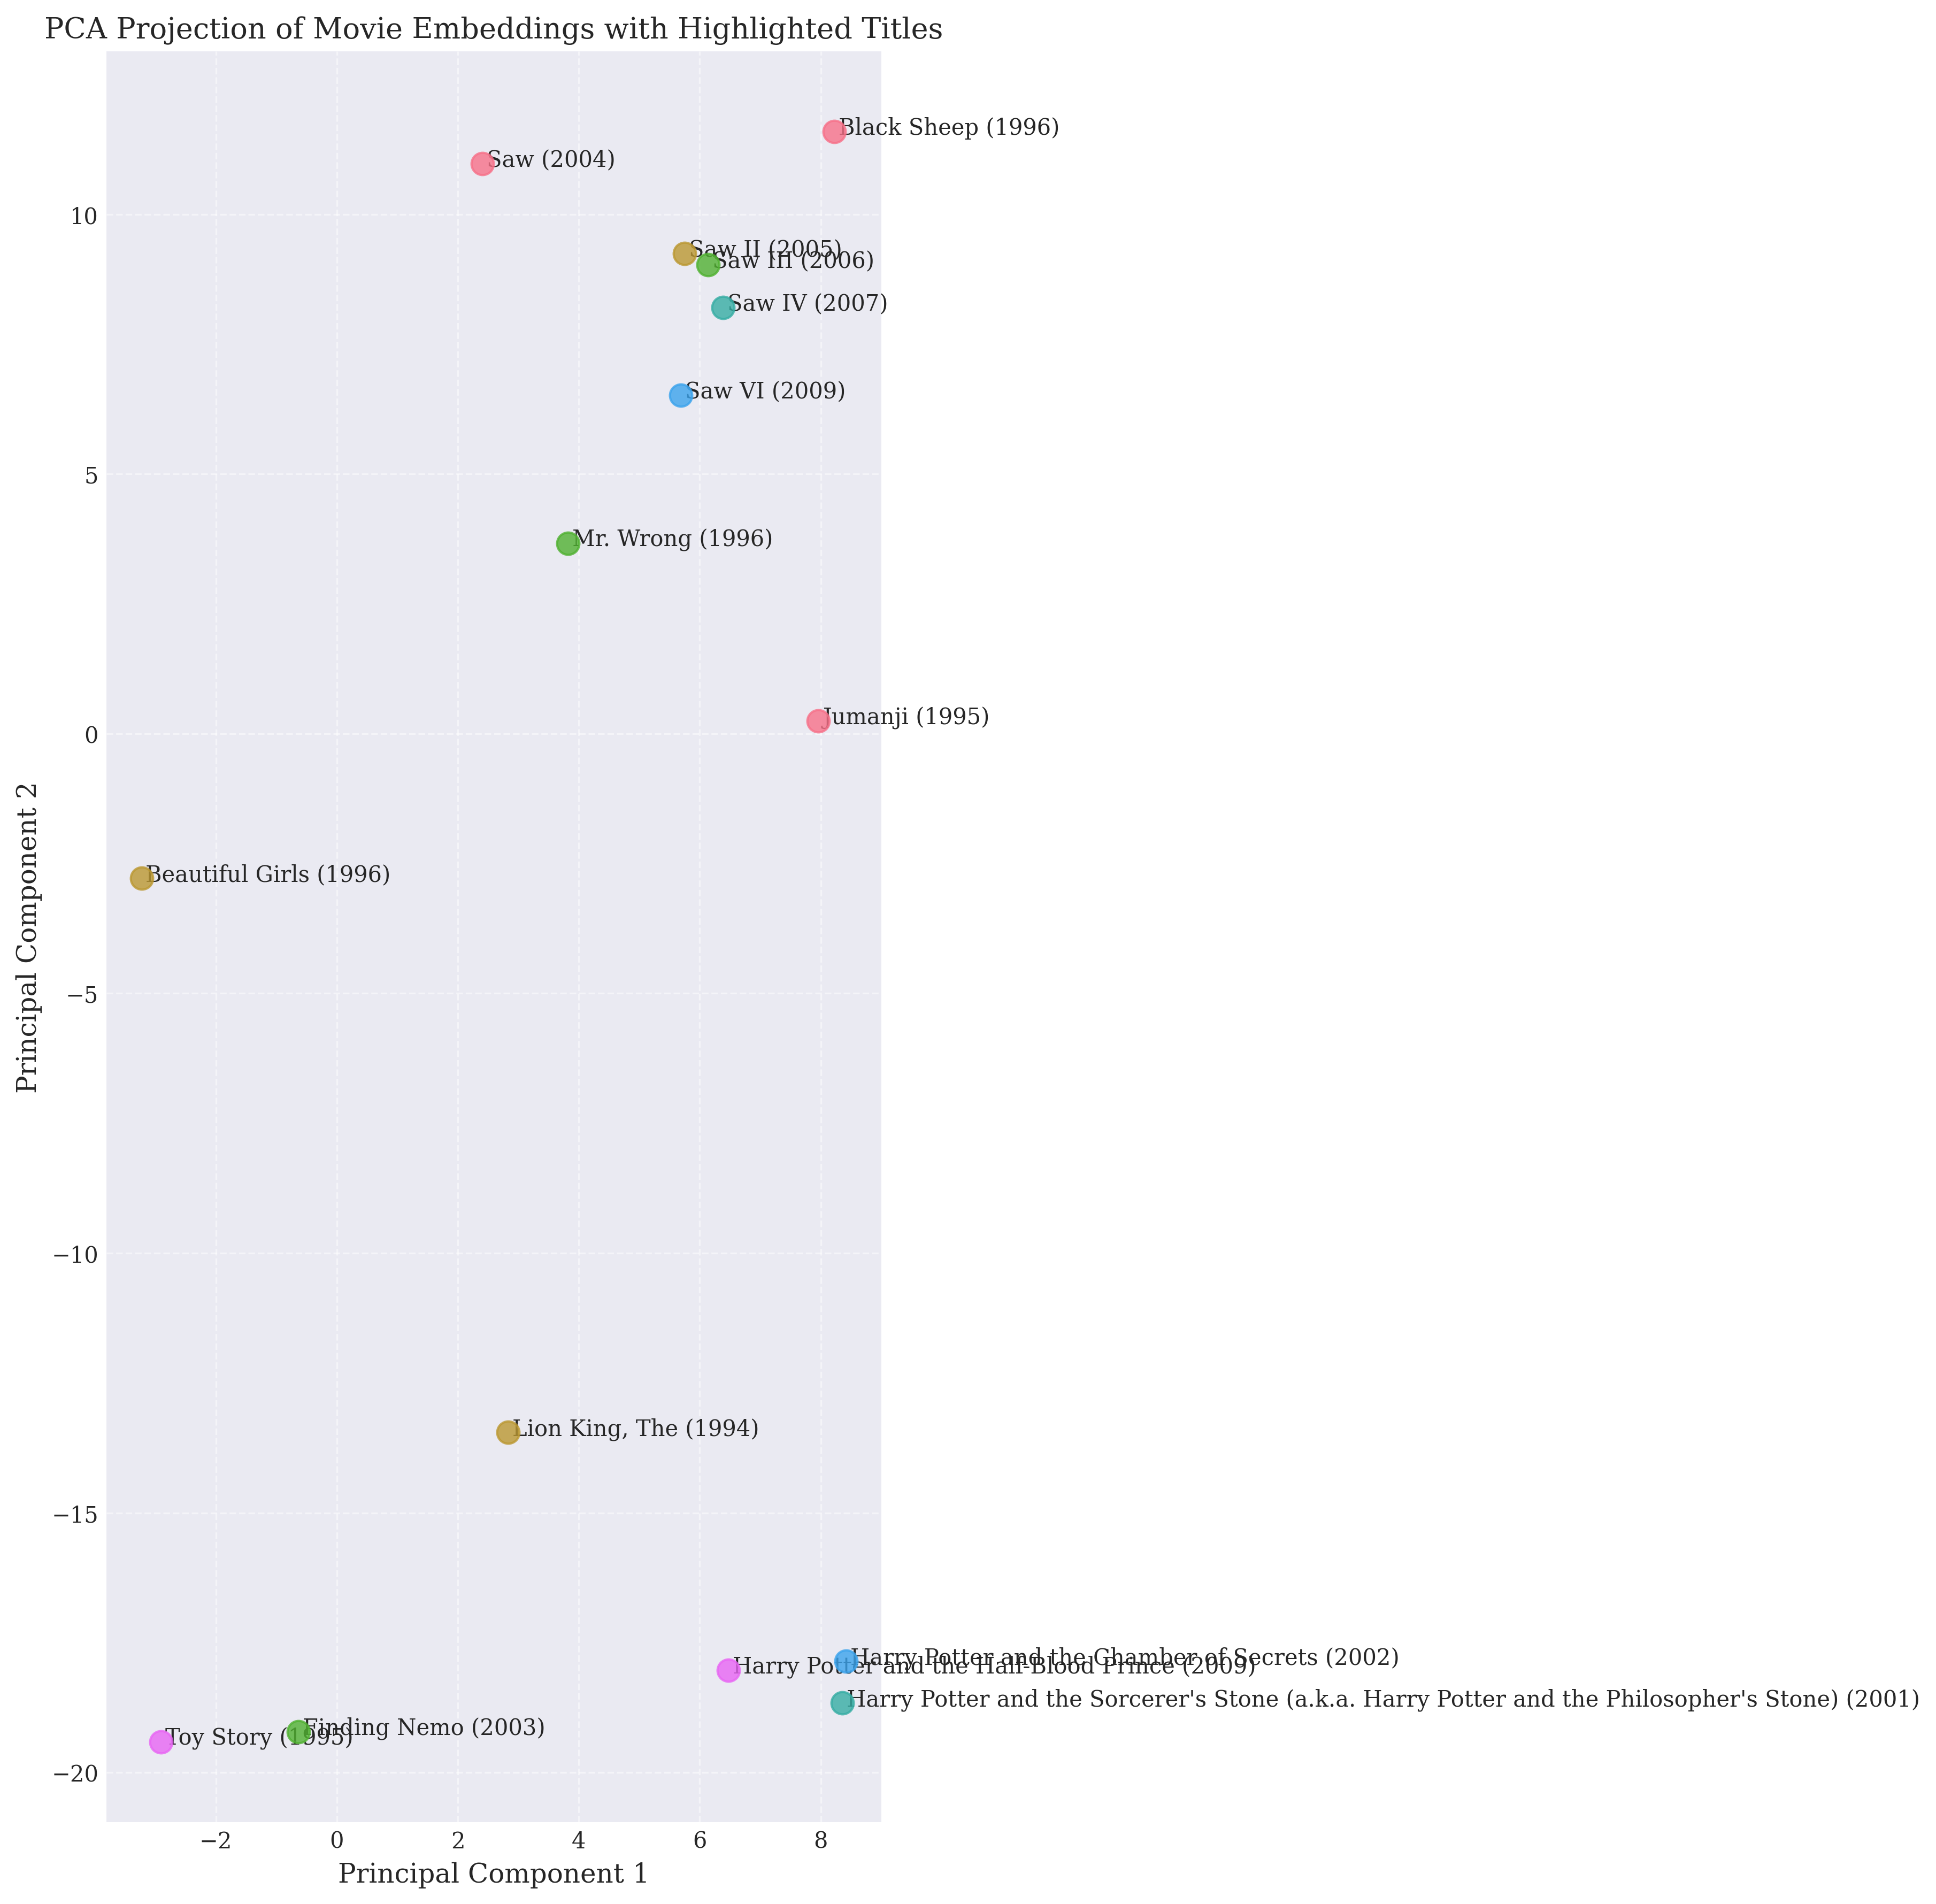

In [39]:
# PCA VISUALIZATION OF SPECIFIC MOVIES

# 1. Transpose (Users as features, Movies as samples)
X_input = movie_embeddings.T

# 2. Standardize
Standarized_movie_embeddings = standard_scaler(X_input)

# 3. Apply PCA
movie_embeddings_2D = pca_2d(Standarized_movie_embeddings)

print("Original Data Shape:", movie_embeddings.shape)
print("Reduced Data Shape:", movie_embeddings_2D.shape)
print()

# 4. Plot specific movies
movie_ids_plot = [8957, 39446, 48877, 55577, 72129, 1, 2, 364, 6377, 4896, 5816, 69844, 88, 94, 102]

plt.figure(figsize=(12, 12))
plt.title("PCA Projection of Movie Embeddings with Highlighted Titles")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle='--', alpha=0.5)

offset = 0.07

# Plot each movie
for movie in movie_ids_plot:
    if movie in ratings_matrix.movieid_to_idx:
        movie_idx_plot = ratings_matrix.movieid_to_idx[movie]

        movie_x = movie_embeddings_2D[movie_idx_plot, 0]
        movie_y = movie_embeddings_2D[movie_idx_plot, 1]

        plt.scatter(movie_x, movie_y, s=100, alpha=0.8, zorder=5)

        # Retrieve and annotate title
        try:
            row = df2[df2['movieId'] == movie][['title']].values[0][0]
            plt.annotate(
                row,
                (movie_x, movie_y),
                xytext=(movie_x + offset, movie_y + offset),
                fontsize=10,
                textcoords='data',
                ha='left',
                va='center'
            )
        except IndexError:
            print(f"Title not found for ID {movie}")

plt.tight_layout()
plt.savefig('plots/pca_movies.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [40]:
# GENRE-SPECIFIC PCA VISUALIZATION

def visualize_specific_genres_pca(ratings_matrix, movie_embeddings, df_movies,
                                  target_genres=['Children', 'Horror', 'Sci-Fi', 'Documentary'],
                                  samples_per_genre=100):


    print(f"1. Sorting movies by popularity...")
    counts = get_movie_counts(ratings_matrix)
    sorted_indices = np.argsort(counts)[::-1]

    print(f"2. Collecting top {samples_per_genre} movies for: {target_genres}...")

    collected_data = {genre: [] for genre in target_genres}
    seen_movies = set()

    # Filter movies by genre
    for idx in sorted_indices:
        # Stop if we have enough samples for all genres
        if all(len(collected_data[g]) >= samples_per_genre for g in target_genres):
            break

        movie_id = ratings_matrix.idx_to_movieid[idx]
        if movie_id in seen_movies:
            continue

        try:
            row = df_movies[df_movies['movieId'] == movie_id].values[0]
            title = row[1]
            genre_str = row[2]

            # Check if movie belongs to any target genre
            for target in target_genres:
                if target in genre_str:
                    if len(collected_data[target]) < samples_per_genre:
                        collected_data[target].append({
                            'embedding': movie_embeddings[:, idx],  # Shape (k,)
                            'title': title,
                            'genre_label': target
                        })
                        seen_movies.add(movie_id)
                        break
        except (IndexError, KeyError):
            continue

    # Prepare data for PCA
    final_embeddings = []
    final_labels = []
    final_titles = []

    for genre in target_genres:
        print(f"   Found {len(collected_data[genre])} movies for '{genre}'")
        for item in collected_data[genre]:
            final_embeddings.append(item['embedding'])
            final_labels.append(item['genre_label'])
            final_titles.append(item['title'])

    # Convert to NumPy array (N_samples, k)
    X = np.array(final_embeddings, dtype=np.float64)

    print(f"3. Running PCA on shape {X.shape}...")

    # Apply standardization and PCA
    X_std = standard_scaler(X)
    pca_results = pca_2d(X_std)

    print("4. Generating PCA Plot...")
    plt.figure(figsize=(14, 10))

    genre_colors = {
        'Children': 'tab:green',
        'Horror': 'black',
        'Comedy': 'tab:red',
        'Documentary': 'tab:blue',
        'Sci-Fi': 'tab:purple'
    }

    # Plot each genre
    for genre in target_genres:
        indices = [i for i, x in enumerate(final_labels) if x == genre]
        if not indices:
            continue

        points_x = pca_results[indices, 0]
        points_y = pca_results[indices, 1]

        plt.scatter(points_x, points_y,
                    c=genre_colors.get(genre, 'gray'),
                    label=genre,
                    s=80, alpha=0.7, edgecolors='white')

        # Annotate a few random titles
        if len(indices) > 0:
            subset_indices = random.sample(indices, min(3, len(indices)))
            for i in subset_indices:
                plt.annotate(final_titles[i],
                             (pca_results[i, 0], pca_results[i, 1]),
                             fontsize=8, weight='bold', alpha=0.8,
                             xytext=(5, 5), textcoords='offset points')

    plt.title(f"PCA Projection of Specific Genres (Top {samples_per_genre} Popular)", fontsize=15)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Genre")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('plots/pca_genre.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

1. Sorting movies by popularity...
2. Collecting top 100 movies for: ['Children', 'Horror', 'Comedy', 'Documentary']...
   Found 100 movies for 'Children'
   Found 100 movies for 'Horror'
   Found 100 movies for 'Comedy'
   Found 100 movies for 'Documentary'
3. Running PCA on shape (400, 20)...
4. Generating PCA Plot...


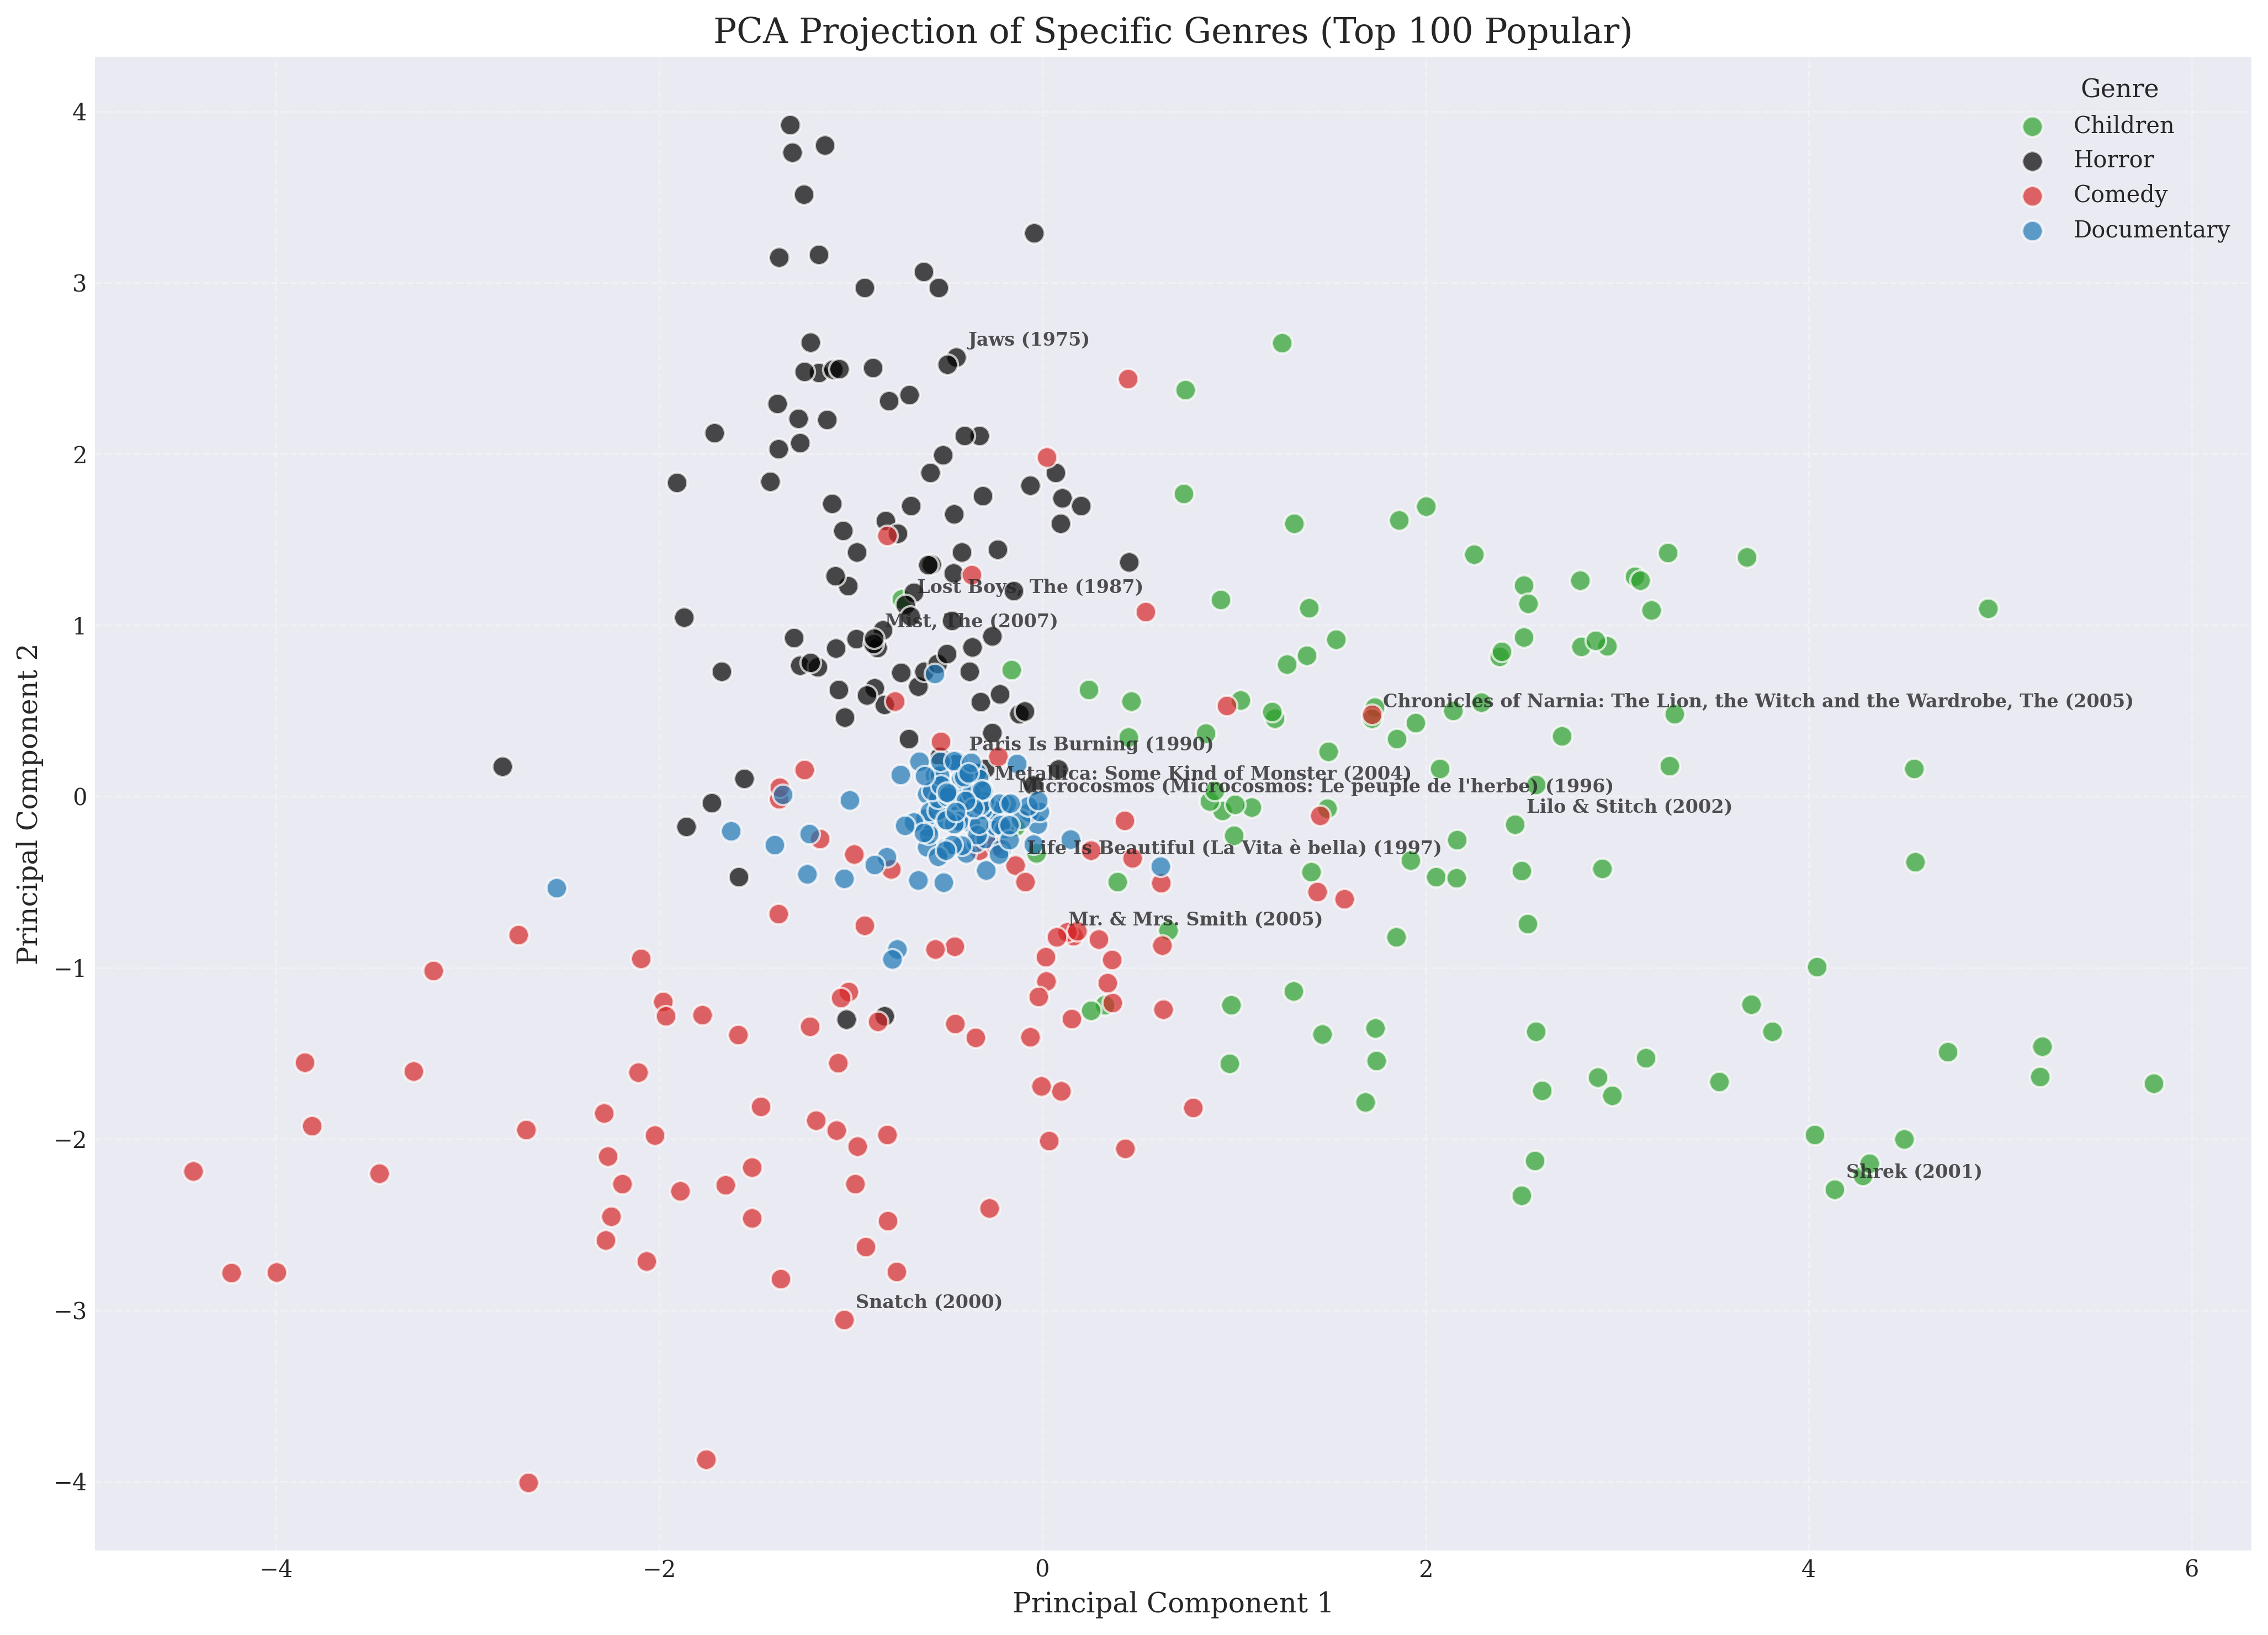

In [41]:
visualize_specific_genres_pca(
    ratings_matrix,
    movie_embeddings,
    df2,
    target_genres=['Children', 'Horror', 'Comedy', 'Documentary'],
    samples_per_genre=100
)